<a href="https://colab.research.google.com/github/samuelhurni/ML-Cellsegmentation-HSLU-FS24/blob/feature_Sam/Sartorius_segmentation_kaggle_Sam_v999.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Sartorius - Cell Instance Segmentation
##Detect single neuronal cells in microscopy images

Project HSLU Master IT Digitalization & Sustainability
Module: Machine Learning and Data Science
* Samuel Hurni
* Pradanendr Sudev  
* Chakravarti Devanandini

This code was programmed from Samuel Hurni and should just be used for individual grading of Samuel Hurni. The other two group members did their work in a separate collab with another approach.

## 0.1 General information and references

Used Third party Libraries:
* Pytorch
* TQDM
* Pandas
* Numpy
* gdown
* Matplotlib

Used Thid party Imports:
* Auxiliary functions metric: "https://www.kaggle.com/code/theoviel/competition-metric-map-iou
* Auxiliary functions for encoding and decoding the mask: "https://www.kaggle.com/code/enzou3/sartorius-mask-r-cnn"

Used model source code and imports:
* Facebook DETR: https://github.com/facebookresearch/detr
* Data model initalization example: https://www.kaggle.com/code/shonenkov/training-efficientdet


References to Turtorials / Code documantation:
* Pytorch documentation: https://pytorch.org/docs/stable/index.html
* Pytorch Turtorial: https://www.learnpytorch.io/00_pytorch_fundamentals/
* Kaggel dataset for ideas: https://www.kaggle.com/code/enzou3/sartorius-mask-r-cnn

Usage of AI tools for code support:
* Copilot Microsoft
* ChatGpt


 **Important:**
  **Please check the Hyperparameters for this File because this allows you for example to differentiate between different mask heads**

## 0.2 About the project

Link to the project as follow: https://www.kaggle.com/competitions/sartorius-cell-instance-segmentation




Main objectives:

This Kaggle competition is about creating a computer program to identify and outline individual nerve cells in microscope images. These nerve cells are important for studying brain diseases like Alzheimer's and brain tumors, which are major health problems worldwide. Typically, scientists look at these cells using a microscope, but finding each cell in the images can be tough and takes a lot of time. Doing this accurately could help find new treatments for these diseases.

The challenge is that current methods aren't very good at recognizing these nerve cells, especially a kind called neuroblastoma cells, which look very different from other cells and are hard to identify with existing tools.

Sartorius, a company that supports science and medicine research, is sponsoring this competition. They want participants to develop a method that can automatically and precisely identify different types of nerve cells in images. This would be a big step forward in neurological research, making it easier for scientists to understand how diseases affect nerve cells and possibly leading to the discovery of new medications.



Dataset:

The Dataset containa at arround 600 images for training and 200 images for testing. the goal would be to train a model whoch is able to segment neuronal cells.


The ground truth data to the images for training consist several meta data which includes also the masks for training the segmentation problem. These are specified field of ecah datapoint:


* _id - unique identifier for object_

* _annotation - run length encoded pixels for the identified neuronal cell_

* _width - source image width_

* _height - source image height_

* _cell_type - the cell line_

* _plate_time - time plate was created_

* _sample_date - date sample was created_

* _sample_id - sample identifier_

* _elapsed_timedelta - time since first image taken of sample_



In [1]:
!git clone https://github.com/facebookresearch/detr.git   #cloning github repo of detr to import its unique loss

Cloning into 'detr'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 265 (delta 0), reused 1 (delta 0), pack-reused 264
Receiving objects: 100% (265/265), 12.88 MiB | 14.68 MiB/s, done.
Resolving deltas: 100% (123/123), done.


# 1.Preparations: Loading Dataset and install or import Packages

## 1.1 Install adn import third party packages / functions

In this chapter we install the third party packages which maybe are not installed in the prebuild google collab or on your local system

* Tqdm --> progress bar
* gdown --> Import google drive package


In [2]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS########################
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
from detr.models.segmentation import PostProcessPanoptic, PostProcessSegm
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

import collections
# General Import which are used in this file
import pandas as pd
import numpy as np
import string
import os.path
import os
from tqdm.auto import tqdm
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
import requests
import requests
import zipfile
from pathlib import Path
import gdown
from sklearn.metrics import fbeta_score

# General Import which are used in this file
import pandas as pd
import numpy as np
import string
import os.path
import os
from tqdm.auto import tqdm
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
import requests
import requests
import zipfile
from pathlib import Path
import gdown
from sklearn.metrics import fbeta_score
import torch
from torchvision.transforms import functional as F
from pathlib import Path
import zipfile
import gdown

import collections
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.ops import box_convert, generalized_box_iou

<ipython-input-2-2a0062f1e750>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Install gdown:
try:
    import gdown
except ImportError:
    !pip install gdown

# Install tqdm:
try:
    import tqdm
except ImportError:
    !pip install tqdm

## 1.2 Define custom functions for this Project:

In this chapter we are defining custom functions which we are using throughout this project:

* `AverageMeter` Computes and stores the average and current value
* `plot_loss_values` for plotting the loss and accuracy to detect under or overfitting


In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
import matplotlib.pyplot as plt
from typing import List, Dict
def plot_loss_values(results_train: List[Dict[str, float]], results_valid: List[Dict[str, float]], losses: List[str]):
    """
    Dynamically plot the loss values based on provided configuration to show if the model is overfitting or underfitting,
    adapting to new data structures where results are lists of dictionaries.

    Args:
    results_train (List[Dict[str, float]]): List of dictionaries with training loss values per epoch.
    results_valid (List[Dict[str, float]]): List of dictionaries with validation loss values per epoch.
    losses (List[str]): List of loss types to plot.
    """
    # Convert lists of dictionaries to dictionaries of lists
    train_converted = {loss: [epoch[loss] for epoch in results_train] for loss in losses}
    valid_converted = {loss: [epoch[loss] for epoch in results_valid] for loss in losses}

    # Determine the number of epochs
    epochs = range(len(results_train))

    # Determine layout size based on the number of loss metrics
    cols = 3  # Number of columns in the plot
    rows = (len(losses) + cols - 1) // cols  # Compute rows needed

    plt.figure(figsize=(5 * cols, 5 * rows))

    for i, loss_name in enumerate(losses):
        plt.subplot(rows, cols, i + 1)
        plt.plot(epochs, train_converted[loss_name], label=f'train_{loss_name}', color='red')
        plt.plot(epochs, valid_converted[loss_name], label=f'valid_{loss_name}', color='blue')
        plt.title(f'{loss_name.capitalize()} Loss')
        plt.xlabel('Epochs')
        plt.legend()

    plt.tight_layout()
    plt.show()


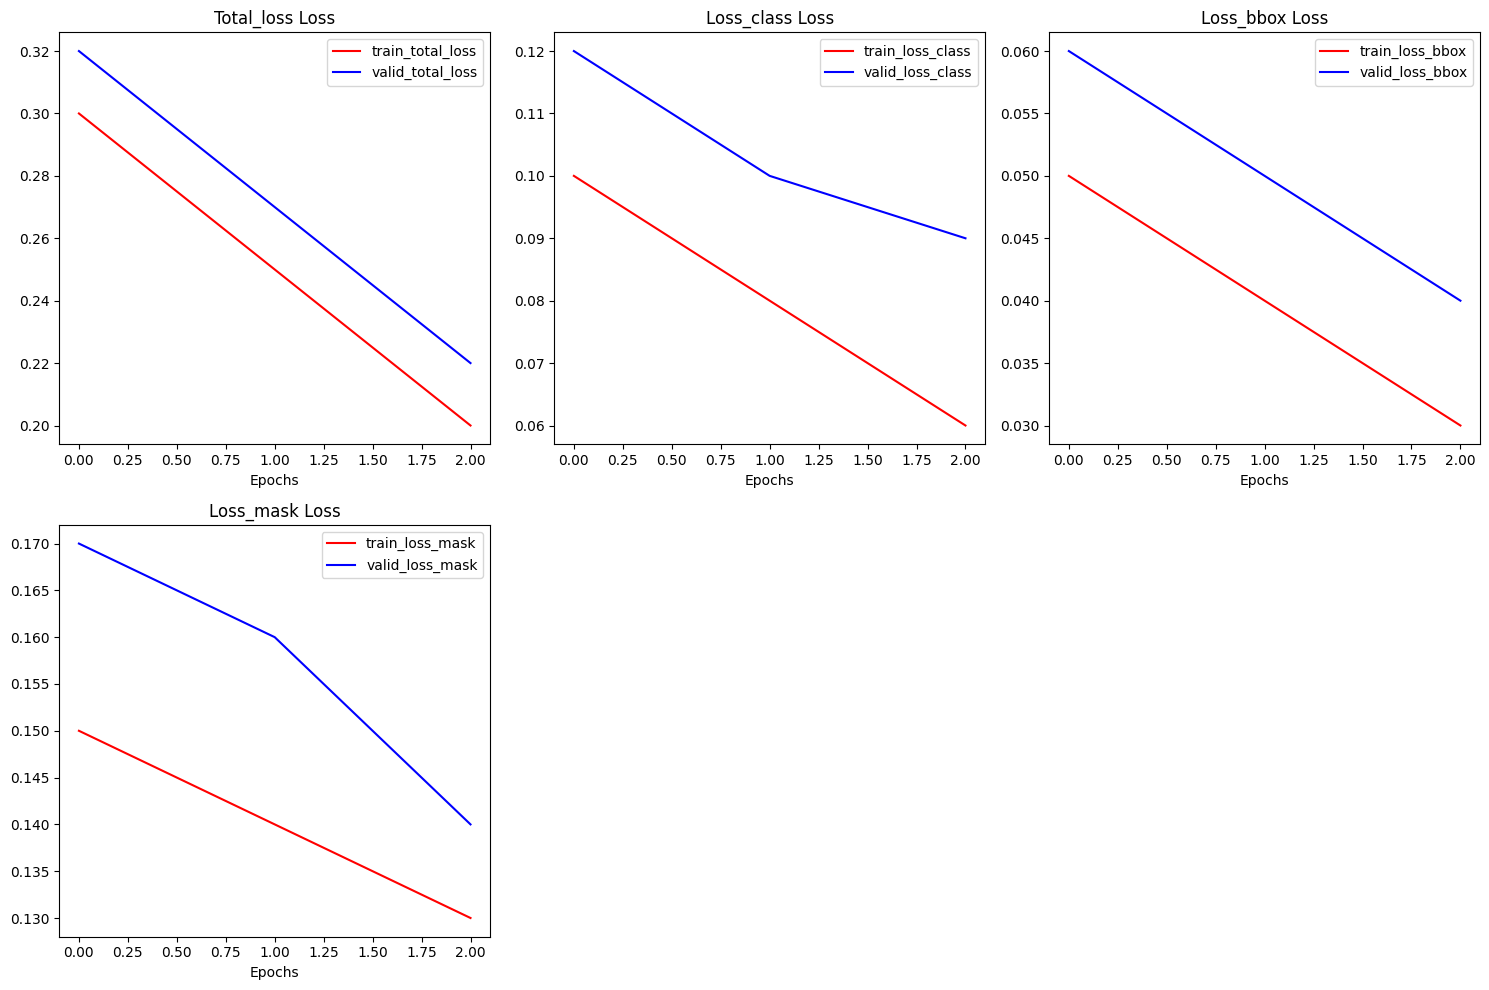

In [6]:
#Test the method with dummy values
results_train = [
    {'total_loss': 0.3, 'loss_class': 0.1, 'loss_bbox': 0.05, 'loss_mask': 0.15},
    {'total_loss': 0.25, 'loss_class': 0.08, 'loss_bbox': 0.04, 'loss_mask': 0.14},
    {'total_loss': 0.2, 'loss_class': 0.06, 'loss_bbox': 0.03, 'loss_mask': 0.13}
]

results_valid = [
    {'total_loss': 0.32, 'loss_class': 0.12, 'loss_bbox': 0.06, 'loss_mask': 0.17},
    {'total_loss': 0.27, 'loss_class': 0.1, 'loss_bbox': 0.05, 'loss_mask': 0.16},
    {'total_loss': 0.22, 'loss_class': 0.09, 'loss_bbox': 0.04, 'loss_mask': 0.14}
]

losses = ['total_loss', 'loss_class', 'loss_bbox', 'loss_mask']

plot_loss_values(results_train, results_valid, losses)


## 1.3 Hyperparameters

This part contains the Hyperparameters for this model approach. Specials would be here that we have two separate learning loops, one for the DETR model and later on for the SEgmentation maslk head.

In [7]:
n_folds = 5
seed = 42
num_classes = 4       # 3 classes and one class: no_object found
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 2
LR_DETR = 1e-5
LR_DETR_SEG = 1e-5
EPOCHS_DETR = 20
EPOCHS_DETR_SEG = 50
OWN_MASK_HEAD = False  #Differentiate between two different mask heads
DEBUG = False         #Enable some Debug prints in general
DEBUG_Train = False   #Enable some Debug prints during training


In [8]:
BASE_PATH = "dataset/sartorius-cell-instance-segmentation"
TRAIN_PATH = BASE_PATH + "/train"
TEST_PATH = BASE_PATH + "/test"
TRAIN_CSV = BASE_PATH + "/train.csv"

IMG_WIDTH = 704
IMG_HEIGHT = 520

RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]

# Dictionaries to classify each type of cell
CELL_TYPE_DICT = {"astro": 0, "cort": 1, "shsy5y": 2}
DICT_TO_CELL = {0: "astro", 1: "cort", 2: "shsy5y"}
MASK_THRESHOLD_DICT = {1: 0.55, 2: 0.75, 3:  0.6}
MIN_SCORE_DICT = {1: 0.55, 2: 0.75, 3: 0.5}

# Normalize to resnet mean and std if True.
NORMALIZE = False

In [9]:
#Random seed code
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [10]:
seed_everything(seed)

#2.Preparing the Data

* This section contains the different preparation for example the augmentations which could be used for trains.

##2.1.Augmentations



In [11]:
def get_train_transforms():
    return A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),

                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.9),

                      A.ToGray(p=0.01),

                      A.HorizontalFlip(p=0.5),

                      A.VerticalFlip(p=0.5),

                      A.Resize(height=512, width=512, p=1),

                      A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),

                      ToTensorV2(p=1.0)],

                      p=1.0,

                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=1.0),
                      ToTensorV2(p=1.0)],
                      p=1.0,
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

## 2.2 Creating Dataset

* DETR accepts data in coco format which is (x,y,w,h)(for those who do not know there are two formats coco and pascal(smin,ymin,xmax,ymax) which are widely used) . So now we need to prepare data in that format

In [12]:
DIR_TRAIN = '../input/global-wheat-detection/train'
def normalize_bbox(bboxes, rows, cols):
    """Normalize coordinates of a bounding box. Divide x-coordinates by image width and y-coordinates
    by image height.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    with minor modification
    """
    normalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        normalized_bbox = (x_min / cols, y_min / rows, x_max / cols, y_max / rows)
        # Check if any of the normalized values are greater than 1
        if any(coord > 1 for coord in normalized_bbox):
            print(f"Normalized values greater than 1 detected: {normalized_bbox}")

        normalized_bboxes.append(normalized_bbox)
    return normalized_bboxes


def denormalize_bbox(bboxes, rows, cols):
    """Denormalize coordinates of a bounding box. Multiply x-coordinates by image width and y-coordinates
    by image height. This is an inverse operation for :func:`~albumentations.augmentations.bbox.normalize_bbox`.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    with minor modification
    """
    denormalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        denormalized_bbox = (x_min * cols, y_min * rows, x_max * cols, y_max * rows)
        denormalized_bboxes.append(denormalized_bbox)
    return denormalized_bboxes

In [13]:
import torchvision
print(torchvision.__version__)

0.17.1+cu121


In [14]:


class ImageCellDataset(Dataset):
    def __init__(self, directory_path, data_frame, transformation_steps=None):
        self.transformation_steps = transformation_steps
        self.directory_path = directory_path
        self.data_frame = data_frame
        self.img_height = IMG_HEIGHT
        self.img_width = IMG_WIDTH
        self.cells_data = collections.defaultdict(dict)

        grouped_df = self.data_frame.groupby(['id', 'cell_type'])['annotation'].apply(list).reset_index()

        for idx, record in grouped_df.iterrows():
            self.cells_data[idx] = {
                'cell_id': record['id'],
                'file_path': os.path.join(self.directory_path, record['id'] + '.png'),
                'cell_annotations': record["annotation"],
                'type': CELL_TYPE_DICT[record["cell_type"]]
            }


    # get the item and load annotations (mask) accordingly
    def __getitem__(self, index):
        cell_data = self.cells_data[index]
        image_file = cell_data["file_path"]
        image = Image.open(image_file).convert("RGB")
        num_objects = len(cell_data['cell_annotations'])
        masks = np.zeros((num_objects, self.img_height, self.img_width), dtype=np.uint8)
        bounding_boxes = []

        for i, annotation in enumerate(cell_data['cell_annotations']):
            decoded_mask = decode_rle(annotation, (self.img_height, self.img_width))
            decoded_mask = Image.fromarray(decoded_mask)
            decoded_mask = np.array(decoded_mask) > 0
            masks[i, :, :] = decoded_mask
            box = find_bounding_box(decoded_mask)

            bounding_boxes.append(box)

        # Prepare labels based on cell type
        labels = [cell_data["type"] for _ in range(num_objects)]

        # Convert bounding_boxes from Corner Points Format to CXCW format
        bounding_boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)  # Ensure bounding_boxes is a torch tensor
        # print(f"Bounding box initial: {bounding_boxes[0]}")

        # print(f"Bounding box after convertion: {bounding_boxes[0]}")
        #bounding_boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        cell_id_tensor = torch.tensor([index])
        areas = (bounding_boxes[:, 3] - bounding_boxes[:, 1]) * (bounding_boxes[:, 2] - bounding_boxes[:, 0])
        not_crowded = torch.zeros((num_objects,), dtype=torch.int64)

        target_dict = {
            'boxes': bounding_boxes,
            'labels': labels,
            'masks': masks,
            'image_id': cell_id_tensor,
            'area': areas,
            'iscrowd': not_crowded
            # 'file_path': image_file
        }


        if self.transformation_steps:
            image, target_dict = self.transformation_steps(image, target_dict)

        # do normalization and conversation here
        boxes = target_dict['boxes']
        converted_boxes = torch.zeros_like(boxes)

        for i, box in enumerate(boxes):
            converted_boxes[i] = box_convert(box, in_fmt='xyxy', out_fmt='cxcywh')
            #print(converted_boxes[i])
        bounding_boxes = converted_boxes
        bounding_boxes = normalize_bbox(bounding_boxes,rows=520,cols=704)
        bounding_boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)  # Ensure bounding_boxes is a torch tensor


        target_dict['boxes'] = bounding_boxes
        return image, target_dict

    def __len__(self):
        return len(self.cells_data)


# 3.Model
In this chapter we would define the model architecture from the DETR model. Since the computation power of the segmentation konfiguration is to big, I need jsut the basic Detection model from facebook without segmentation head and build my segmentation head on top.

For the mask head I did two approaches in this collab. Ones is by using  more or less the same architecture as in the source code from facebook. This architecture could just be trained wiht the A100 GPU which provides more than 16Gb GPU Ram.

Therefore I added also a second mask head architecture, whoch is leaner and could be trained with the Tesla T4 GPU on Collab.

In this apporach I basically used the configuration of 'num_querries = 100' because otherwhose the pretrained weights for the object detection part does not match anymore and a training from scratch is needed. The dataset contains some images where up to 721 objects were in there. The average is even thought around 100 objects per image. For a realistic comparison, a training from scratch with num_queries  = 800 needs to be done. According to Facebook a training took them 3 days with 8 GPUs in parallel. This could not be done in the scope of this project!


The illustration below show a fully detailed architecture of the DETR model:
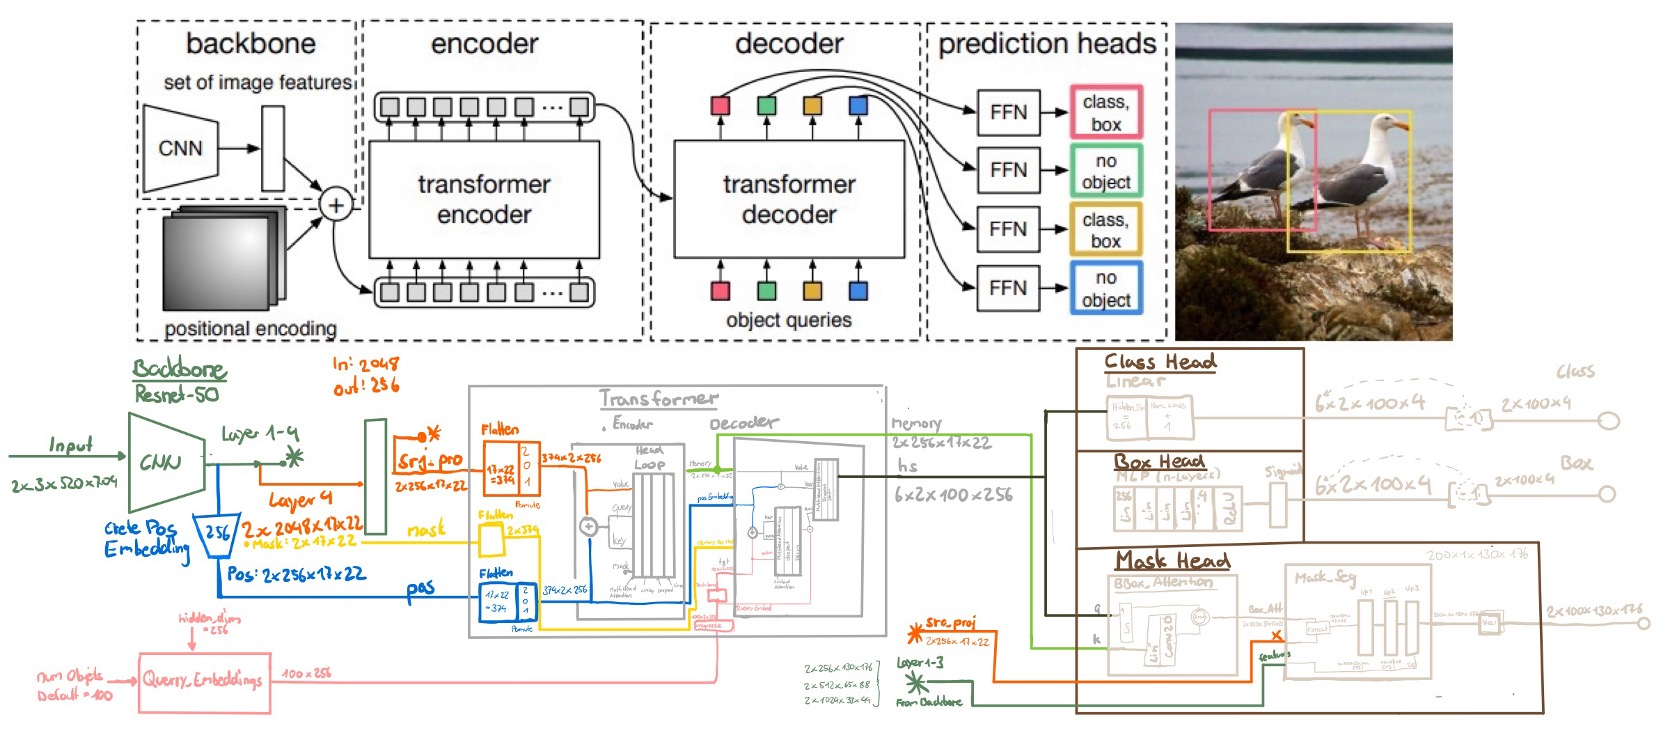


### 3.0 Model customized mask Heads

This section cntains two different approaches for mask heads after the object detection.

* `MHAttentionMap` builds the Attention Map after the detection to later been upsammpled to segmentations masks
* `MaskHeadSmallConv` Architecture close to Facebooks apporach for upsampling the attention masks  to final segmentations masks
*`UpdatedSimplifiedMaskHead` Leaner upsampling approach to use the Tesla T4 GPU for training

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional
from torch import Tensor

class MHAttentionMap(nn.Module):
    """This is a 2D attention module, which only returns the attention softmax (no multiplication by value)"""

    def __init__(self, query_dim, hidden_dim, num_heads, dropout=0.0, bias=True):
        super().__init__()
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout)

        self.q_linear = nn.Linear(query_dim, hidden_dim, bias=bias)
        self.k_linear = nn.Linear(query_dim, hidden_dim, bias=bias)

        nn.init.zeros_(self.k_linear.bias)
        nn.init.zeros_(self.q_linear.bias)
        nn.init.xavier_uniform_(self.k_linear.weight)
        nn.init.xavier_uniform_(self.q_linear.weight)
        self.normalize_fact = float(hidden_dim / self.num_heads) ** -0.5

    def forward(self, q, k, mask: Optional[Tensor] = None):
        q = self.q_linear(q)
        k = F.conv2d(k, self.k_linear.weight.unsqueeze(-1).unsqueeze(-1), self.k_linear.bias)
        qh = q.view(q.shape[0], q.shape[1], self.num_heads, self.hidden_dim // self.num_heads)
        kh = k.view(k.shape[0], self.num_heads, self.hidden_dim // self.num_heads, k.shape[-2], k.shape[-1])
        weights = torch.einsum("bqnc,bnchw->bqnhw", qh * self.normalize_fact, kh)

        if mask is not None:
            weights.masked_fill_(mask.unsqueeze(1).unsqueeze(1), float("-inf"))
        weights = F.softmax(weights.flatten(2), dim=-1).view(weights.size())
        weights = self.dropout(weights)
        return weights

In [16]:

def _expand(tensor, length: int):
    return tensor.unsqueeze(1).repeat(1, int(length), 1, 1, 1).flatten(0, 1)
from typing import List, Optional

class MaskHeadSmallConv(nn.Module):
    """
    Simple convolutional head, using group norm.
    Upsampling is done using a FPN approach
    """

    def __init__(self, dim, fpn_dims, context_dim):
        super().__init__()

        inter_dims = [dim, context_dim // 2, context_dim // 4, context_dim // 8, context_dim // 16, context_dim // 64]
        self.lay1 = torch.nn.Conv2d(dim, dim, 3, padding=1)
        self.gn1 = torch.nn.GroupNorm(8, dim)
        self.lay2 = torch.nn.Conv2d(dim, inter_dims[1], 3, padding=1)
        self.gn2 = torch.nn.GroupNorm(8, inter_dims[1])
        self.lay3 = torch.nn.Conv2d(inter_dims[1], inter_dims[2], 3, padding=1)
        self.gn3 = torch.nn.GroupNorm(8, inter_dims[2])
        self.lay4 = torch.nn.Conv2d(inter_dims[2], inter_dims[3], 3, padding=1)
        self.gn4 = torch.nn.GroupNorm(8, inter_dims[3])
        self.lay5 = torch.nn.Conv2d(inter_dims[3], inter_dims[4], 3, padding=1)
        self.gn5 = torch.nn.GroupNorm(8, inter_dims[4])
        self.out_lay = torch.nn.Conv2d(inter_dims[4], 1, 3, padding=1)

        self.dim = dim

        self.adapter1 = torch.nn.Conv2d(fpn_dims[0], inter_dims[1], 1)
        self.adapter2 = torch.nn.Conv2d(fpn_dims[1], inter_dims[2], 1)
        self.adapter3 = torch.nn.Conv2d(fpn_dims[2], inter_dims[3], 1)
        self.upsample_to_target = nn.Upsample(size=(520, 704), mode='bilinear', align_corners=False)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                nn.init.constant_(m.bias, 0)
    def forward(self, x: Tensor, bbox_mask: Tensor, fpns: List[Tensor]):
        x = torch.cat([_expand(x, bbox_mask.shape[1]), bbox_mask.flatten(0, 1)], 1)
        #print("Concat layer", x.shape)
        x = self.lay1(x)
        x = self.gn1(x)
        x = F.relu(x)
        x = self.lay2(x)
        x = self.gn2(x)
        x = F.relu(x)
        #print("Upsamling 0: " ,fpns[0].shape)
        cur_fpn = self.adapter1(fpns[0])
        if cur_fpn.size(0) != x.size(0):
            cur_fpn = _expand(cur_fpn, x.size(0) // cur_fpn.size(0))
        x = cur_fpn + F.interpolate(x, size=cur_fpn.shape[-2:], mode="nearest")
        x = self.lay3(x)
        x = self.gn3(x)
        x = F.relu(x)
        #print("Upsamling 1: ", fpns[1].shape)
        cur_fpn = self.adapter2(fpns[1])
        if cur_fpn.size(0) != x.size(0):
            cur_fpn = _expand(cur_fpn, x.size(0) // cur_fpn.size(0))
        x = cur_fpn + F.interpolate(x, size=cur_fpn.shape[-2:], mode="nearest")
        x = self.lay4(x)
        x = self.gn4(x)
        x = F.relu(x)
        #print("Upsamling 2: ", fpns[2].shape)
        cur_fpn = self.adapter3(fpns[2])
        if cur_fpn.size(0) != x.size(0):
            cur_fpn = _expand(cur_fpn, x.size(0) // cur_fpn.size(0))
        x = cur_fpn + F.interpolate(x, size=cur_fpn.shape[-2:], mode="nearest")
        x = self.lay5(x)
        x = self.gn5(x)
        x = F.relu(x)

        x = self.out_lay(x)
        x  = self.upsample_to_target(x)
        return x

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UpdatedSimplifiedMaskHead(nn.Module):
    def __init__(self, input_dim, fpn_dims):
        super().__init__()
        self.conv1 = nn.Conv2d(input_dim + 1, input_dim // 2, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(input_dim // 2, input_dim // 4, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(input_dim // 4, 1, kernel_size=1)
        self.upsample_to_target = nn.Upsample(size=(520, 704), mode='bilinear', align_corners=False)

    def forward(self, x, bbox_masks, fpn_features):
        batch_size, num_queries, _, height, width = bbox_masks.size()
        output_masks = []

        for i in range(num_queries):
            # Process each query's bbox mask individually
            bbox_mask = bbox_masks[:, i, :, :, :]
            # Average across the 8 channels of the bbox_mask
            bbox_mask = bbox_mask.mean(dim=1, keepdim=True)
            bbox_mask_upsampled = F.interpolate(bbox_mask, size=x.shape[-2:], mode='bilinear', align_corners=False)
            x_with_mask = torch.cat([x, bbox_mask_upsampled], dim=1)

            x1 = self.conv1(x_with_mask)
            x1 = self.relu(x1)
            x1 = self.conv2(x1)
            x1 = self.relu(x1)
            mask = self.final_conv(x1)
            mask = self.upsample_to_target(mask)
            output_masks.append(mask)

        # Stack all masks to match the batch and queries size
        output_masks = torch.stack(output_masks, dim=1)  # Shape will be [batch_size, num_queries, 1, 130, 176]
        return output_masks


### 3.1 Model Definitions

In this section, we use a define and load the DETR Model from the torch Hub for object detection. Afterwards we define a own segmentation version from it called `DETRPanopticModel`. this model uses the before defined mask heads, according to the configuration of `OWN_MASK_HEAD`

In [18]:
class DETRModel(nn.Module):
    def __init__(self, num_classes, num_queries):
        super(DETRModel, self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries

        # Load the pre-trained DETR model
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)


        # Change the number of queries by adjusting the query embedding matrix
        self.model.query_embed = nn.Embedding(self.num_queries, self.model.transformer.d_model)

        # Adjust the class embedding layer to the number of classes
        self.in_features = self.model.class_embed.in_features
        self.model.class_embed = nn.Linear(in_features=self.in_features, out_features=self.num_classes)
        hidden_dim = 256  # Example value, adjust as necessary
        self.mask_head = MaskHeadSmallConv(hidden_dim + 1, hidden_dim, num_queries)  # Adjust +1 based on concatenated attn map

    def forward(self, images):
        return self.model(images)

In [19]:
from detr.util.misc import NestedTensor, interpolate, nested_tensor_from_tensor_list

class DETRPanopticModel(nn.Module):
    def __init__(self, num_classes, num_queries):
        super(DETRPanopticModel, self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries

        # Load the pre-trained DETR model for panoptic segmentation
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50_panoptic', pretrained=True)

        # Change the number of queries by adjusting the query embedding matrix
        self.model.detr.query_embed = nn.Embedding(self.num_queries, self.model.detr.transformer.d_model)

        # # Adjust the class embedding layer to the number of classes for the detection head
        self.in_features = self.model.detr.class_embed.in_features
        self.model.detr.class_embed = nn.Linear(in_features=self.in_features, out_features=self.num_classes)

        hidden_dim, nheads = self.model.detr.transformer.d_model, self.model.detr.transformer.nhead
        self.bbox_attention = MHAttentionMap(hidden_dim, hidden_dim, nheads, dropout=0.0)
        #self.mask_head = MaskHeadSmallConv(hidden_dim + nheads, [1024, 512, 256], hidden_dim)
        hidden_dim = 256
        fpn_dims = [1024, 512, 256]
        if OWN_MASK_HEAD:
          self.mask_head = UpdatedSimplifiedMaskHead(hidden_dim, fpn_dims) #--> own mask head
        else:
          self.mask_head = MaskHeadSmallConv(hidden_dim + nheads, [1024, 512, 256], hidden_dim)


        hidden_dim = 256  # Example hidden_dim from DETR model
        fpn_dims = [1024, 512, 256]  # Example FPN dimensions
        num_queries = 100  # Example number of queries
        #self.mask_head = MaskHeadSmallConv2(hidden_dim, fpn_dims, num_queries)

    def forward(self, images):
        if isinstance(images, (list, torch.Tensor)):
            images = nested_tensor_from_tensor_list(images)
        features,pos   = self.model.detr.backbone(images)
        if DEBUG:
          print("Type of backbone features is: ", len(features) )
          print("Shape of backbone features is: ", features[3].tensors.shape) #torch.Size([2, 256, 130, 176]) 256 = embedding / channel
        # 4 index because of 4 outputs layers of detr
        # index1: torch.Size([2, 256, 130, 176])
        # index2: torch.Size([2, 512, 65, 88])
        # index3: torch.Size([2, 1024, 33, 44])
          #print("Shape of backbone features is: ", features[2].tensors)
          print("Shape of backbone features is: ", features[2].mask.shape) #torch.Size([2, 130, 176])
          #print("Shape of backbone features is: ", features[2].mask) #True/False masks
          print("Shape of backbone pos is: ", len(pos) )
          print("Shape of backbone pos is: ", pos[3].shape )

        bs = features[-1].tensors.shape[0]
        if DEBUG:
          print("Shape of backbone bs is: ", bs )
        src, mask = features[-1].decompose()
        if DEBUG:
          print("Shape of backbone src is: ", src.shape )
          print("Shape of backbone mask is: ", mask.shape )
        assert mask is not None
        src_proj = self.model.detr.input_proj(src)
        if DEBUG:
          print("Shape of backbone src_proj is: ", src_proj.shape )
          print("query embeddings weight ", self.model.detr.query_embed.weight.shape)
        hs, memory = self.model.detr.transformer(src_proj, mask, self.model.detr.query_embed.weight, pos[-1])
        if DEBUG:
          print("Shape of transformer hs  is: ", hs.shape )
          print("Shape of transformer memory  is: ", memory.shape )

        outputs_class = self.model.detr.class_embed(hs)
        if DEBUG:
          print("Shape of outputs_class   is: ", outputs_class.shape )

        outputs_coord = self.model.detr.bbox_embed(hs).sigmoid()
        if DEBUG:
          print("Shape of outputs_coord   is: ", outputs_coord.shape )

        out = {"pred_logits": outputs_class[-1], "pred_boxes": outputs_coord[-1]}
        if self.model.detr.aux_loss:
            out['aux_outputs'] = self.model.detr._set_aux_loss(outputs_class, outputs_coord)

        # FIXME h_boxes takes the last one computed, keep this in mind
        bbox_mask = self.bbox_attention(hs[-1], memory, mask=mask)
        if DEBUG:
          print("Shape of bbox_mask   is: ", bbox_mask.shape )
          print("Shape of x for mask head input is: ", src_proj.shape )
          print(f"Shape fpn_features input is: of array 0:{features[2].tensors.shape} 1:{features[1].tensors.shape} 2:{features[0].tensors.shape}")
        #seg_masks = self.mask_head(src_proj, bbox_mask, [features[2].tensors, features[1].tensors, features[0].tensors])
        hidden_dim = 256  # Example hidden dimension from the DETR model
        fpn_dims = [1024, 512, 256]  # Example FPN dimensions from ResNet-50 backbone
        bbox_dim = 1  # Dimension of the bounding box mask feature
        if OWN_MASK_HEAD:
          seg_masks = self.mask_head(src_proj, bbox_mask, [features[2].tensors, features[1].tensors, features[0].tensors])
        else:
          seg_masks = self.mask_head(src_proj, bbox_mask, [features[2].tensors, features[1].tensors, features[0].tensors])

        outputs_seg_masks = seg_masks.view(bs, self.model.detr.num_queries, seg_masks.shape[-2], seg_masks.shape[-1])

        #seg_masks = self.mask_head(src_proj, bbox_mask, [features[2].tensors, features[1].tensors, features[0].tensors]) comment in for own
        if DEBUG:
          print("Shape of seg_masks   is: ", seg_masks.shape)
        #outputs_seg_masks = seg_masks.view(bs, self.model.detr.num_queries, seg_masks.shape[-2], seg_masks.shape[-1]) comment in for own
        if DEBUG:
          print("Shape final masks  is: ", outputs_seg_masks.shape)
        # seg_masks = self.mask_head(src_proj, bbox_mask, [features[2].tensors, features[1].tensors, features[0].tensors])
        # outputs_seg_masks = seg_masks.view(bs, self.model.detr.num_queries, seg_masks.shape[-2], seg_masks.shape[-1])
        out["pred_masks"] = outputs_seg_masks
        return out

## 3.2 Matcher and Bipartite Matching Loss

Now we make use of the unique loss that the model uses and for that we need to define the matcher. DETR calcuates three individual losses :
* Classification Loss for labels(its weight can be set by loss_ce)
* Bbox Loss (its weight can be set by loss_bbox)
* Loss for Background class

How the Hungarian Matcher function could be seen in the below bibliograhpy

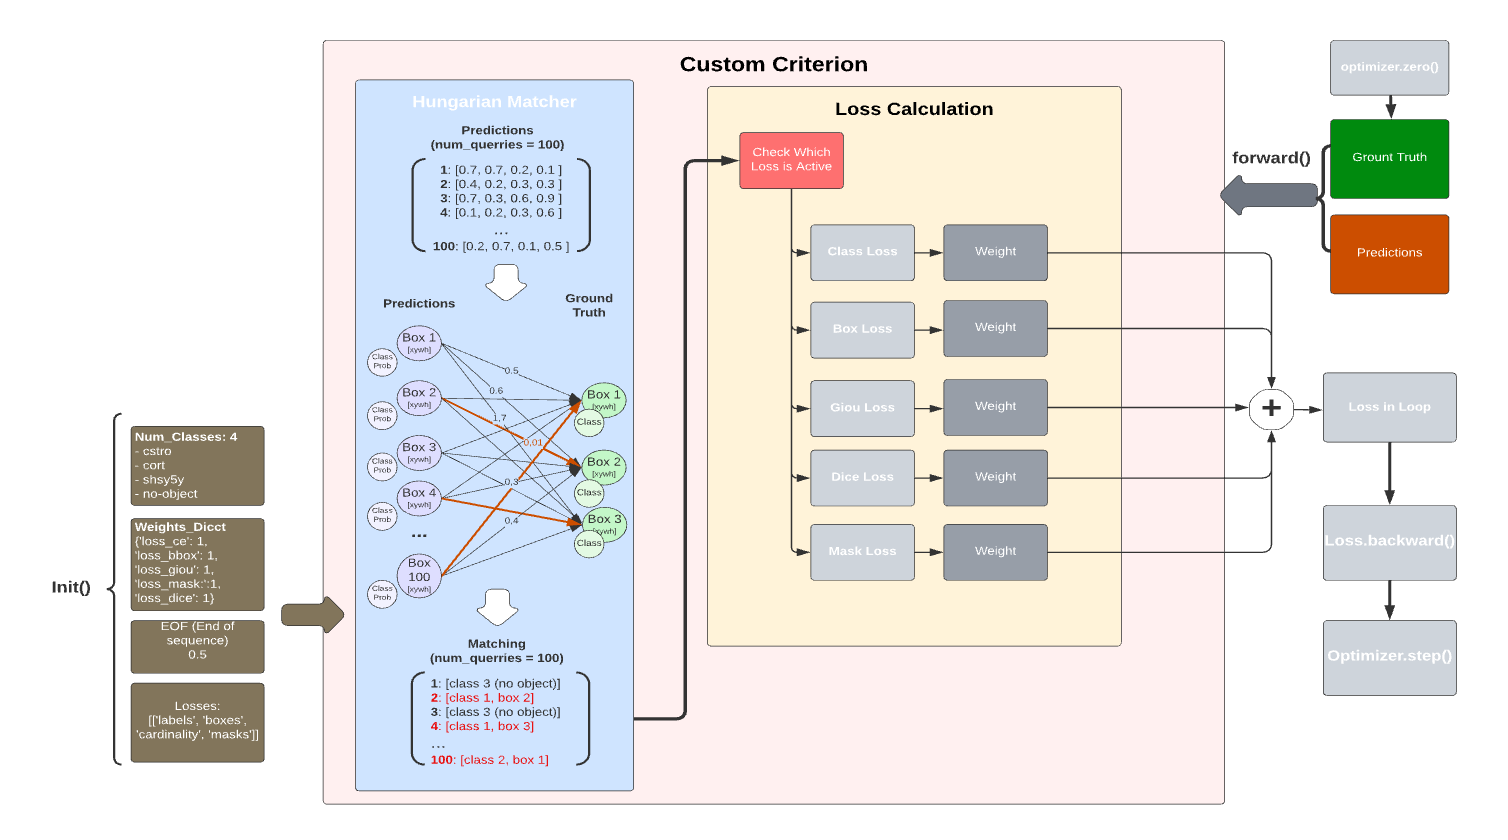

In [20]:
'''
code taken from github repo detr , 'code present in engine.py'
'''

matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

In [21]:
def transform_targets(targets):
    # Initialize the new list structure
    targets_new = []

    # Assuming all lists in 'targets' are of the same length
    for i in range(len(next(iter(targets.values())))):  # Iterate through the length of any list in 'targets'
        # Construct new dict for each index, pulling the corresponding item from each list in 'targets'
        new_dict = {key: value[i] for key, value in targets.items()}
        targets_new.append(new_dict)

    return targets_new

## 3.3 Training Function

In this chapter we would define a general training function which is would train the model for one epoche. this training loop could be used to train both, the detection part and final the segmentation head.

In [22]:
from tqdm import tqdm
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch, train_segmentation=False):
    model.train()
    criterion.train()

    summary_loss = AverageMeter()
    # Temporary storage for accumulating loss values
    epoch_losses = defaultdict(float)
    loss_counts = defaultdict(int)

    # Dictionary to store average epoch loss values for plotting later
    results_train = defaultdict(float)
    # Verify settings
    # for name, param in model.named_parameters():
    #     print(name, param.requires_grad)
    tk0 = tqdm(data_loader, total=len(data_loader))

    for step, (images, targets) in enumerate(tk0):

        images = list(image.to(device) for image in images)
        for key in list(targets.keys()):
          if isinstance(targets[key][0], torch.Tensor):  # Check if the first item is a tensor
              targets[key] = [item.to(device) for item in targets[key]]
        #print("Input Shape: ", images[0].shape)
        #print("Input Data: ", images[0])
        output = model(images)
        #print("Output  boxes: ", output['pred_boxes'])
        targets_new = transform_targets(targets)

        #ground_truth_labels = torch.stack(targets['labels'], dim=0) # shape list with len --> shape [batch_size,num objects in image]
        #print(output['pred_logits'].shape)
        probabilities = torch.sigmoid(output['pred_logits'])
        # Find the indices of the max probabilities
        max_indices = torch.argmax(probabilities, dim=-1)
        # Check how often the max index is not the last index (index 3)
        not_last_index_count = torch.sum(max_indices != (4 - 1))
        num_objects_gt = targets_new[0]['labels'].shape[0] + targets_new[1]['labels'].shape[0]
        missing_objects = num_objects_gt-not_last_index_count
        #print(f"Objects found: {not_last_index_count.item()} objects loss: {missing_objects}", )
        loss_dict = criterion(output, targets_new)
        weight_dict = criterion.weight_dict
        # Initialize losses as None to dynamically set it later
        losses = None
        if train_segmentation:
          if DEBUG_Train:
            print("masks are:" , output['pred_masks'].shape)
            print(loss_dict.items())
            print("Loss mask: ", loss_dict['loss_mask'])
            print("Loss dice: ", loss_dict['loss_dice'])

        for k, loss_value in loss_dict.items():
            if k in weight_dict and loss_value.requires_grad:
                weighted_loss = loss_value * weight_dict[k]
                epoch_losses[k] += weighted_loss.item()  # Sum weighted losses for averaging
                loss_counts[k] += 1
                if losses is None:
                    losses = weighted_loss
                else:
                    losses += weighted_loss

        #print(f"Loss are: {losses}")
        # Ensure losses is not None and has gradients before proceeding
        if losses is None or not losses.requires_grad:
            print("Warning: No gradients in any loss components; nothing to backpropagate.")
            continue
        # # Print requires_grad for each loss component
        # #losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        # # Sum only losses that have gradients
        # losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict and loss_dict[k].requires_grad)
        #print(f"Loss requires grad: {losses.requires_grad}")  # Check if loss requires gradients

        optimizer.zero_grad()
        if not losses.requires_grad:
          raise ValueError("No gradients in loss computation; check loss inputs.")


        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)
        #print( print(epoch_losses))
        # for k in epoch_losses:
        #   if loss_counts[k] > 0:
        #       results_train[k].append(epoch_losses[k] / loss_counts[k])
        #print( print(epoch_losses))

    results_train['total_loss'] = summary_loss.avg
    for k, loss_value in loss_dict.items():
      if loss_counts[k] > 0:
        print(f"Loss value {k} with the final loss {epoch_losses[k]/ loss_counts[k]}")
        results_train[k] = epoch_losses[k]/ loss_counts[k]

    return summary_loss, dict(results_train)



## 3.4 Eval Function

The same case would be also valid for the evaluation function. the difference would be that we do not calculate the gradients and do not learn the weihgts in this sequence

In [23]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    epoch_losses = defaultdict(float)
    loss_counts = defaultdict(int)

    # Dictionary to store average epoch loss values for plotting later
    results_valid = defaultdict(float)

    with torch.no_grad():
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets) in enumerate(tk0):

            images = list(image.to(device) for image in images)
            for key in list(targets.keys()):
              if isinstance(targets[key][0], torch.Tensor):  # Check if the first item is a tensor
                  targets[key] = [item.to(device) for item in targets[key]]

            output = model(images)
            targets_new = transform_targets(targets)
            #ground_truth_labels = torch.stack(targets['labels'], dim=0) # shape list with len --> shape [batch_size,num objects in image]
            probabilities = torch.sigmoid(output['pred_logits'])
            # Find the indices of the max probabilities
            max_indices = torch.argmax(probabilities, dim=-1)
            # Check how often the max index is not the last index (index 3)
            not_last_index_count = torch.sum(max_indices != (4 - 1))
            num_objects_gt = targets_new[0]['labels'].shape[0] + targets_new[1]['labels'].shape[0]
            missing_objects = num_objects_gt-not_last_index_count
            #print(f"Objects found: {not_last_index_count.item()} objects loss: {missing_objects}", )

            loss_dict = criterion(output, targets_new)
            weight_dict = criterion.weight_dict

            losses = None
            for k, loss_value in loss_dict.items():
              if k in weight_dict:
                  weighted_loss = loss_value * weight_dict[k]
                  epoch_losses[k] += weighted_loss.item()  # Sum weighted losses for averaging
                  loss_counts[k] += 1
                  if losses is None:
                      losses = weighted_loss
                  else:
                      losses += weighted_loss

            if losses is None:
              print("Warning: No gradients in any loss components; nothing to backpropagate.")
              continue
            # losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)

            # for k in epoch_losses:
            #   if loss_counts[k] > 0:
            #       results_valid[k].append(epoch_losses[k] / loss_counts[k])

    results_valid['total_loss'] = summary_loss.avg
    for k, loss_value in loss_dict.items():
      if loss_counts[k] > 0:
        print(f"Loss value {k} with the final loss {epoch_losses[k]/ loss_counts[k]}")
        results_valid[k] = epoch_losses[k]/ loss_counts[k]
    return summary_loss, dict(results_valid)



#### 3.4.1 COCO Evaluation method

In this section all the necessary functions are defined to do the evaluation of the dataset with the COCO API. the following references were used for this:
* https://cocodataset.org/#home
* https://pypi.org/project/pycocotools/

The code contains two functions:
* `prepare_for_coco_segmentation` which creates objects for predictions and ground truths whoch could be later on converted into a json file. It brings the data also in the right format
* `eval_fn_coco`whis is a modified version of the eval method, which creates at the end the coco evaluation for the dataset

In [24]:
import numpy as np
import base64
from scipy.special import expit as sigmoid  # Importing sigmoid function
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools.mask import encode
def prepare_for_coco_segmentation(predictions_masks, predictions_logits, targets_labels, targets_masks):
    annotation_id = 1  # Unique ID for each annotation
    coco_predictions = []
    coco_targets = []
    for image_id, ((prediction_masks, prediction_logits), (target_labels, target_masks)) in enumerate(zip(zip(predictions_masks, predictions_logits), zip(targets_labels, targets_masks))):
        print(f"Image Id: {image_id}")
        # Get scores and labels
        pred_scores = prediction_logits.softmax(-1).max(-1)[0].cpu().numpy()
        pred_labels = prediction_logits.softmax(-1).max(-1)[1].cpu().numpy() + 1
        print("pred labels shape", pred_labels.shape)
        print("pred labels: ", pred_labels)
        # Convert prediction masks to COCO format
        limit_objects = 0
        for mask, score, label in zip(prediction_masks.cpu().numpy(), pred_scores, pred_labels):
            if limit_objects < 5:
              # Applying sigmoid to convert outputs to [0, 1] range
              mask_prob = sigmoid(mask)
              # print(label.shape)
              mask_binary = (mask_prob > 0.5).astype(np.uint8)
              if np.any(mask_binary) and label != 4:  # Check if the mask is not entirely zero
                  rle = encode(np.asfortranarray(mask_binary))
                  if rle:  # Ensure rle is not None
                      rle_str = base64.b64encode(rle['counts']).decode()  # Encode and convert to string
                      #print(rle_str)# Create coco annotation predciction for every mask
                      coco_pred = {
                          'image_id': image_id,
                          'category_id': int(label),
                          'segmentation': {'size': rle['size'], 'counts': rle_str},
                          'score': float(score),
                          'id': annotation_id
                      }
                      coco_predictions.append(coco_pred)
                      annotation_id += 1
              limit_objects += 1


        print(f"Len of annotations is {len(coco_predictions)}")
        # Convert ground truth masks to COCO format
        for mask, label in zip(target_masks.cpu().numpy(), target_labels.cpu().numpy()):
            mask_binary = (mask > 0.5).astype(np.uint8)
            if np.any(mask_binary):  # Check if the mask is not entirely zero
                rle = encode(np.asfortranarray(mask_binary))
                if rle:  # Ensure rle is not None
                    rle_str = base64.b64encode(rle['counts']).decode()
                    coco_gt = {
                        'image_id': image_id,
                        'category_id': int(label) + 1,
                        'segmentation': {'size': rle['size'], 'counts': rle_str},
                        'area': int(np.sum(mask_binary)),
                        'iscrowd': 0,
                        'id': annotation_id
                    }
                    coco_targets.append(coco_gt)
            annotation_id += 1

    return coco_predictions, coco_targets


In [25]:
import json

def eval_fn_coco(data_loader, model,criterion, device, train_segmentation=False):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    epoch_losses = defaultdict(float)
    loss_counts = defaultdict(int)
    coco_predictions = []
    coco_targets = []
    coco_predictions_box = []
    coco_targets_box = []
    # Dictionary to store average epoch loss values for plotting later
    results_valid = defaultdict(float)
    annotation_id = 1
    image_id = 0
    with torch.no_grad():

        tk0 = tqdm(data_loader, total=len(data_loader))
        eval_step = 0
        for step, (images, targets) in enumerate(tk0):
            if eval_step < 10:
              images = list(image.to(device) for image in images)
              for key in list(targets.keys()):
                if isinstance(targets[key][0], torch.Tensor):  # Check if the first item is a tensor
                    targets[key] = [item.to(device) for item in targets[key]]

              output = model(images)
              targets_new = transform_targets(targets)

              #ground_truth_labels = torch.stack(targets['labels'], dim=0) # shape list with len --> shape [batch_size,num objects in image]
              probabilities = torch.sigmoid(output['pred_logits'])
              # Find the indices of the max probabilities
              max_indices = torch.argmax(probabilities, dim=-1)
              # Check how often the max index is not the last index (index 3)
              not_last_index_count = torch.sum(max_indices != (4 - 1))
              num_objects_gt = targets_new[0]['labels'].shape[0]
              missing_objects = num_objects_gt-not_last_index_count
              #print(f"Objects found: {not_last_index_count.item()} objects loss: {missing_objects}", )

              loss_dict = criterion(output, targets_new)
              weight_dict = criterion.weight_dict

              losses = None
              for k, loss_value in loss_dict.items():
                if k in weight_dict:
                    weighted_loss = loss_value * weight_dict[k]
                    epoch_losses[k] += weighted_loss.item()  # Sum weighted losses for averaging
                    loss_counts[k] += 1
                    if losses is None:
                        losses = weighted_loss
                    else:
                        losses += weighted_loss

              if losses is None:
                print("Warning: No gradients in any loss components; nothing to backpropagate.")
                continue

              # losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
              #Coco dataset eval
              if train_segmentation:
                #print(type(targets['masks']))
                #print(type(targets['masks']))
                pred_coco, gt_coco, annotation_id_result = prepare_for_coco_segmentation(output['pred_masks'], output['pred_logits'], targets['labels'][0], targets['masks'][0],annotation_id, image_id)
                annotation_id = annotation_id_result
                image_id = image_id + 1
                #print(type("Test 2"))
                #pred_coco_box, gt_coco_box = prepare_for_coco_box(output['pred_masks'], output['pred_logits'], targets['labels'], targets['boxes'])
                # coco_predictions_box.extend(pred_coco_box)
                # coco_targets_box.extend(gt_coco_box)
                coco_predictions.extend(pred_coco)
                coco_targets.extend(gt_coco)

              summary_loss.update(losses.item(),BATCH_SIZE)
              tk0.set_postfix(loss=summary_loss.avg)
              eval_step = eval_step + 1

    results_valid['total_loss'] = summary_loss.avg
    for k, loss_value in loss_dict.items():
      if loss_counts[k] > 0:
        print(f"Loss value {k} with the final loss {epoch_losses[k]/ loss_counts[k]}")
        results_valid[k] = epoch_losses[k]/ loss_counts[k]

    #print(json.dumps(coco_predictions, indent=4))
    #print("Now targets")
    #print(json.dumps(coco_targets, indent=4))
    if train_segmentation:
        # Define the overall structure for the COCO dataset files
        coco_dataset_predictions = {
            "images": [{"id": idx , "height":520, "width":704 } for idx in range(len(data_loader.dataset))],
            "categories": [
              {
                "id": 1,
                "name": "class1"
              },
              {
                "id": 2,
                "name": "class2"
              },
              {
                "id": 3,
                "name": "class3"
              }
            ],  # Adjust 'num_classes' accordingly
            "annotations": coco_predictions
        }
        coco_dataset_targets = {
           "images": [{"id": idx, "height":520, "width":704 } for idx in range(len(data_loader.dataset))],
            "categories": [
              {
                "id": 1,
                "name": "class1"
              },
              {
                "id": 2,
                "name": "class2"
              },
              {
                "id": 3,
                "name": "class3"
              }
            ],  # Adjust 'num_classes' accordingly
            "annotations": coco_targets
        }

        # Save to JSON files
        with open('temp_coco_predictions.json', 'w') as f:
            json.dump(coco_dataset_predictions, f)
        with open('temp_coco_targets.json', 'w') as f:
            json.dump(coco_dataset_targets, f)

        # Load annotations and predictions
        cocoGt = COCO('temp_coco_targets.json')
        cocoDt = cocoGt.loadRes(coco_predictions)

        # Initialize COCOeval object
        cocoEval = COCOeval(cocoGt, cocoDt, 'segm')
        cocoEval.evaluate()
        cocoEval.accumulate()
        cocoEval.summarize()

        # # Precision and recall are available in cocoEval.eval
        # precision = cocoEval.eval['precision']
        # recall = cocoEval.eval['recall']

        # # Assume you have some thresholds or just take mean
        # mean_precision = precision.mean(axis=2)  # Average over IoU thresholds
        # plt.figure(figsize=(7, 5))
        # plt.plot(recall, mean_precision, marker='o')
        # plt.xlabel('Recall')
        # plt.ylabel('Precision')
        # plt.title('Precision-Recall Curve')
        # plt.grid(True)
        # plt.show()

    return summary_loss, dict(results_valid)



In [26]:
import numpy as np
import base64
from pycocotools.mask import encode, decode
import torch
import numpy as np
import base64
from scipy.special import expit as sigmoid  # Importing sigmoid function
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools.mask import encode
import numpy as np
import base64
from scipy.special import expit as sigmoid  # Importing sigmoid function
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools.mask import encode
from pycocotools.mask import toBbox

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def prepare_for_coco_segmentation(predictions_masks, predictions_logits, target_labels, target_masks, start_annotation_id=1, image_id_outside=1):
    annotation_id = start_annotation_id  # Start from the passed ID
    coco_predictions = []
    coco_targets = []
    prediction_logits = predictions_logits[0]
    prediction_masks = predictions_masks[0]

    # Convert logits to probabilities and then to labels and scores
    pred_scores = prediction_logits.softmax(-1).max(-1)[0].cpu().numpy()
    pred_labels = prediction_logits.softmax(-1).max(-1)[1].cpu().numpy() + 1

    limit_objects = 0
    for mask, score, label in zip(prediction_masks.cpu().numpy(), pred_scores, pred_labels):
        if limit_objects < 500:  # Limit the number of objects processed for simplicity
            mask_prob = sigmoid(mask)
            mask_binary = (mask_prob > 0.5).astype(np.uint8)
            area = np.sum(mask_binary)  # Summing up the 1s in the binary mask
            #print("area of mask" , area)
            if np.any(mask_binary) and label != 4:  # Exclude certain classes if needed
                rle = encode(np.asfortranarray(mask_binary))
                rle['counts'] = rle['counts'].decode('utf-8')  # Decode byte string
                coco_pred = {
                    'image_id': image_id_outside,
                    'category_id': int(label),
                    'segmentation': rle,
                    'score': float(score),
                    'id': annotation_id
                }
                coco_predictions.append(coco_pred)
                annotation_id += 1
            limit_objects += 1

    for mask, label in zip(target_masks.cpu().numpy(), target_labels.cpu().numpy()):
        mask_binary = (mask > 0.5).astype(np.uint8)
        if np.any(mask_binary):
            rle = encode(np.asfortranarray(mask_binary))
            rle['counts'] = rle['counts'].decode('utf-8')
            coco_gt = {
                'image_id': image_id_outside,
                'category_id': int(label) + 1,
                'segmentation': rle,
                'area': int(np.sum(mask_binary)),
                'iscrowd': 0,
                'id': annotation_id
            }
            coco_targets.append(coco_gt)
            annotation_id += 1

    return coco_predictions, coco_targets, annotation_id


#4.Engine
This chapter contains the whole process for loading the dataset and run the training validation and COCO Eval loop. The whole process could be also seen in the illustration below:

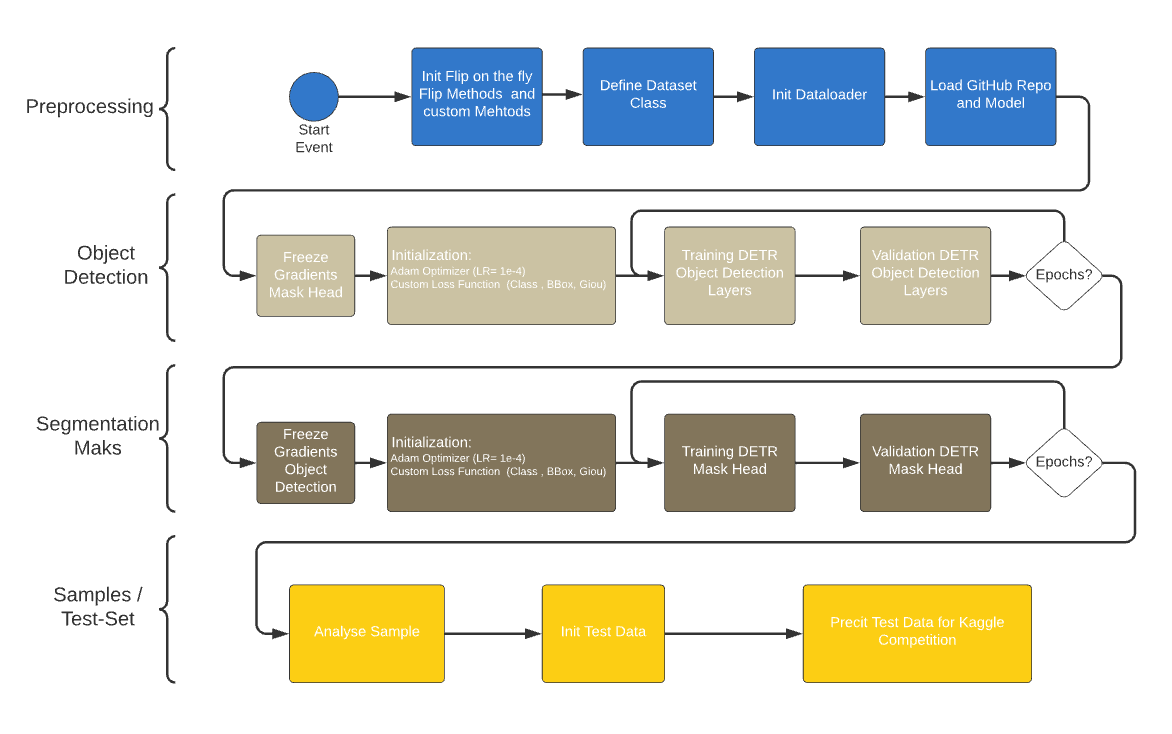

### 4.1 Preparation

this chapter contains also several functions for handling specific function in the dataset:

* `merge_masks` --> merge masks together
* `find_boundingbox`: Get bounding boxes from a segmentation mask
* `decode_rle`: Decodes a run-length encoded string into a binary mask.
* `encode_rle`: Encodes a binary image matrix into a run-length encoding string.
* `eliminate_overlaps`: Removes pixels from the primary mask where it overlaps with any of the additional masks.
* `merge_masks_and_boxes`: Combines mask and box images into one, ensuring that the boxes overlay the masks and have the highest value present in the mask image.

Additional here are several transformation methods defined to allow a transofrmation / augmentation on the fly during training.

* `FlipVertically`
* `FlipHorizontally`
* `Normalize`


In [27]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [28]:
from pathlib import Path
import zipfile
import gdown

# Setup paths and folders names and urls
data_path = Path("dataset")
download_path = Path("kaggledownload")

#dataset_url = 'https://drive.google.com/uc?id=1syZoLGGeFiFErCFL_iI1VO_4k2jLEaPv&confirm=t'
dataset_url = 'https://drive.google.com/uc?id=15XRITzdvdmE4HIsU9oAFgsipIARc_rhF&confirm=t'


# If the image folder doesn't exist, download it
if data_path.is_dir():
    print(f"{data_path} directory exists.")
else:
    print(f"Did not find {data_path} directory, creating one...")
    data_path.mkdir(parents=True, exist_ok=True)
    download_path.mkdir(parents=True, exist_ok=True)

print("Downloading dataset...")
gdown.download(dataset_url, str(download_path / "sartorius-cell-instance-segmentation.zip"), quiet=False)


Did not find dataset directory, creating one...


Downloading...
From: https://drive.google.com/uc?id=15XRITzdvdmE4HIsU9oAFgsipIARc_rhF&confirm=t
To: /content/kaggledownload/sartorius-cell-instance-segmentation.zip
100%|██████████| 2.48G/2.48G [01:18<00:00, 31.6MB/s]


'kaggledownload/sartorius-cell-instance-segmentation.zip'

In [29]:
# Unzip data
with zipfile.ZipFile(str(download_path / "sartorius-cell-instance-segmentation.zip"), "r") as zip_ref:
    print("Unzipping train dataset data...")
    zip_ref.extractall(data_path)

Unzipping train dataset data...


In [30]:
import numpy as np
def decode_rle(rle_string, dimensions, fill_value=1):
  """
  Decodes a run-length encoded string into a binary mask.

  Parameters:
  - rle_string: The run-length encoded string (e.g., "2 3 5 2" means start at 2, length 3, start at 5, length 2)
  - dimensions: Tuple indicating the shape of the output mask (height, width)
  - fill_value: The value to fill the mask with where the RLE indicates; default is 1

  Returns:
  - A 2D numpy array representing the mask, where filled areas are marked with `fill_value` and the rest are 0.
  """

  # Split the RLE string into a list of strings, then convert every string into an integer
  numbers = [int(num) for num in rle_string.split()]

  # Extract start positions and lengths from the list of numbers
  start_positions = numbers[::2]
  lengths = numbers[1::2]

  # Calculate end positions for each run
  end_positions = [start + length for start, length in zip(start_positions, lengths)]

  # Initialize a flat image array with zeros
  flat_image = np.zeros(dimensions[0] * dimensions[1], dtype=np.float32)

  # Fill the specified positions in the flat image array
  for start, end in zip(start_positions, end_positions):
      flat_image[start:end] = fill_value

  # Reshape the flat image array back into the specified dimensions
  return flat_image.reshape(dimensions)

import numpy as np

def encode_rle(image_matrix):
  """
  Encodes a binary image matrix into a run-length encoding string.

  Parameters:
  - image_matrix: A 2D numpy array representing the image to be encoded. Expected to contain binary values (0s and 1s).

  Returns:
  - A string representing the run-length encoded image, where each pair of numbers represents a start position and the length of consecutive 1s.
  """

  # Find indices of all 1s in the flattened image array
  one_positions = np.where(image_matrix.flatten() == 1)[0]

  # Initialize the list to hold the encoding
  encoding = []

  # Track the previous position to determine the start of a new run
  previous_position = -2

  # Iterate through all positions of 1s
  for position in one_positions:
      # If current position is not consecutive, start a new run
      if position > previous_position + 1:
          encoding.extend((position + 1, 0))  # +1 for 1-based indexing
      encoding[-1] += 1  # Increment the length of the current run
      previous_position = position

  # Join all elements in the list as a string separated by spaces
  return ' '.join(map(str, encoding))

def eliminate_overlaps(primary_mask, additional_masks):
  """
  Removes pixels from the primary mask where it overlaps with any of the additional masks.

  Parameters:
  - primary_mask: A 2D numpy array representing the primary mask to be modified.
  - additional_masks: A list of 2D numpy arrays, each representing a mask to check for overlaps with the primary mask.

  Returns:
  - The modified primary mask with overlapping pixels set to 0.
  """

  # Iterate through each of the additional masks
  for mask in additional_masks:
      # Find overlapping pixels between the primary mask and the current additional mask
      overlap = np.logical_and(primary_mask, mask)

      # Check if there is any overlap
      if np.sum(overlap) > 0:
          # Set overlapping pixels in the primary mask to 0
          primary_mask[overlap] = 0

  # Return the modified primary mask
  return primary_mask

import numpy as np

def create_boxed_image(coordinates):
    """
    Draws a rectangular box on an image represented by a numpy array, based on given coordinates.

    Parameters:
    - coordinates: A list of four elements representing the box's corners [xmin, ymin, xmax, ymax].

    Returns:
    - A 2D numpy array (image) with dimensions IMG_HEIGHT x IMG_WIDTH,
      where pixels inside the box are set to 1, and the rest are 0.
    """

    # Initialize a blank image with zeros
    image = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    # Extract and convert the box coordinates to integers
    xmin, ymin, xmax, ymax = map(int, coordinates)

    # Draw top and bottom lines of the box
    for x in range(xmin, xmax):
        if xmin != 0 and xmax != IMG_WIDTH:  # Check to prevent drawing outside the image
            image[ymin-1][x] = 1  # Draw top line
            image[ymax-1][x] = 1  # Draw bottom line

    # Draw left and right lines of the box
    for y in range(ymin, ymax):
        if ymin != 0 and ymax != IMG_HEIGHT:  # Check to prevent drawing outside the image
            image[y][xmax-1] = 1  # Draw right line
            image[y][xmin-1] = 1  # Draw left line

    # Return the image with the drawn box
    return image

import numpy as np

def find_bounding_box(mask):
    """
    Calculates the bounding box of a non-zero area in a mask.

    Parameters:
    - mask: A 2D numpy array representing the mask from which to calculate the bounding box.

    Returns:
    - A list containing the coordinates of the bounding box: [xmin, ymin, xmax, ymax].
    """

    # Find the indices of non-zero elements in the mask
    nonzero_indices = np.where(mask)

    # Calculate the minimum and maximum x (column) indices
    left_bound = np.min(nonzero_indices[1])
    right_bound = np.max(nonzero_indices[1])

    # Calculate the minimum and maximum y (row) indices
    top_bound = np.min(nonzero_indices[0])
    bottom_bound = np.max(nonzero_indices[0])

    # Return the bounding box coordinates
    return [left_bound, top_bound, right_bound, bottom_bound]

def merge_masks(mask_list, threshold):
    """
    Merges multiple masks into a single image, assigning a unique integer to each mask's area based on its order in the list,
    but only for mask values above a specified threshold.

    Parameters:
    - mask_list: A list of 2D numpy arrays (masks) to be merged. Each mask should have the same dimensions.
    - threshold: A value that defines the minimum intensity for pixels to be considered part of a mask.

    Returns:
    - A 2D numpy array where each pixel's value corresponds to the order of the mask it belongs to,
      or 0 if it does not belong to any mask or does not meet the threshold.
    """

    # Initialize an empty image with the same dimensions as the masks
    combined_image = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    # Iterate through each mask with its order starting from 1
    for order, mask in enumerate(mask_list, 1):
        # Update the combined image with the order number where the mask exceeds the threshold
        #print(order)
        #print(mask.shape)
        combined_image[mask > threshold] = order

    return combined_image

import numpy as np

def merge_masks_and_boxes(mask_image, box_image):
    """
    Combines mask and box images into one, ensuring that the boxes overlay the masks and
    have the highest value present in the mask image.

    Parameters:
    - mask_image: A 2D numpy array representing multiple masks, where non-zero values indicate mask presence.
    - box_image: A 2D numpy array representing multiple boxes, marked as 1's for box edges and 0's for the background.

    Returns:
    - A 2D numpy array where both boxes and masks are combined. Boxes will overlay masks with the highest mask value found.
    """

    # Initialize a result image with zeros
    combined_image = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    # Find the highest value in the mask_image
    max_mask_value = np.max(mask_image)

    # First pass: Copy mask values to the combined image
    for x in range(IMG_WIDTH):
        for y in range(IMG_HEIGHT):
            combined_image[y, x] = mask_image[y, x]

    # Second pass: Overlay boxes on the combined image, setting them to the highest mask value
    for x in range(IMG_WIDTH):
        for y in range(IMG_HEIGHT):
            if box_image[y, x] != 0:  # If there's a box pixel, overlay it with the max mask value
                combined_image[y, x] = max_mask_value

    return combined_image

In [31]:
# transformation functions
# Adjustments to PyTorch transformation classes to accommodate masks and targets
# Inspired by Abishek and DATAISTA0's approach

import torch
import random
from torchvision.transforms import functional as TF

RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]

class FlipVertically:
    def __init__(self, likelihood):
        self.likelihood = likelihood

    def __call__(self, pic, label):
        if random.random() < self.likelihood:
            pic_height, pic_width = pic.shape[-2:]
            pic = pic.flip(-2)
            box = label["boxes"]
            box[:, [1, 3]] = pic_height - box[:, [3, 1]]
            label["boxes"] = box
            label["masks"] = label["masks"].flip(-2)
        return pic, label

class FlipHorizontally:
    def __init__(self, likelihood):
        self.likelihood = likelihood

    def __call__(self, pic, label):
        if random.random() < self.likelihood:
            pic_height, pic_width = pic.shape[-2:]
            pic = pic.flip(-1)
            box = label["boxes"]
            box[:, [0, 2]] = pic_width - box[:, [2, 0]]
            label["boxes"] = box
            label["masks"] = label["masks"].flip(-1)
        return pic, label





class Normalize:
    """Normalize tensor image with mean and standard deviation."""
    def __call__(self, pic, label):
        pic = TF.normalize(pic, mean=RESNET_MEAN, std=RESNET_STD)
        return pic, label

class ConvertToTensor:
    """Convert PIL Image or numpy.ndarray to Tensor."""
    def __call__(self, pic, label):
        # Ensure pic is converted to a tensor using torchvision's functional API
        pic = TF.to_tensor(pic)
        return pic, label




def get_transforms(training):
    base_transforms = [ConvertToTensor()]
    if training:
        # Augmentations for the training dataset
        augmentations = [
            FlipHorizontally(likelihood=0.5),  # Assuming a 50% chance to apply
            FlipVertically(likelihood=0.5),  # Assuming a 50% chance to apply
        ]
        base_transforms.extend(augmentations)

    # Always apply normalization last
    base_transforms.append(Normalize())

    return Compose(base_transforms)


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, label):
        for t in self.transforms:
            image, label = t(image, label)
        return image, label



In [32]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
def custom_collate_fn(batch):
    images, targets = zip(*batch)  # Unpack the batch of images and targets
    images = torch.stack(images, dim=0)  # Stack images as they should be of the same size

    # Handle variable-sized targets manually
    # Assuming targets is a dictionary with keys like 'boxes', 'labels', etc.
    # We'll collect these into lists or whatever format your model expects
    collated_targets = {}
    for key in targets[0].keys():
        if isinstance(targets[0][key], torch.Tensor):
            # For tensor-type data that's variable-sized, use a list to avoid size mismatch issues
            collated_targets[key] = [target[key] for target in targets]
        else:
            # Use default_collate for data that can be directly collated
            collated_targets[key] = default_collate([target[key] for target in targets])

    return images, collated_targets


# Load your dataset DataFrame
df_train = pd.read_csv(TRAIN_CSV)

df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

# Initialize your full dataset with transformations
#full_dataset = ImageCellDataset(directory_path=TRAIN_PATH, data_frame=df_train, transformation_steps=get_transforms(training=True))

train_dataset = ImageCellDataset(directory_path=TRAIN_PATH, data_frame=df_train, transformation_steps=get_transforms(training=True))
valid_dataset = ImageCellDataset(directory_path=TRAIN_PATH, data_frame=df_val, transformation_steps=get_transforms(training=False))


valid_dataset_coco = ImageCellDataset(directory_path=TRAIN_PATH, data_frame=df_val, transformation_steps=get_transforms(training=False))
train_dataset_coco = ImageCellDataset(directory_path=TRAIN_PATH, data_frame=df_train, transformation_steps=get_transforms(training=False))

# Initialize DataLoaders for the train and validation subsets
dl_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)
dl_val = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)
print(len(valid_dataset_coco))
dl_val_coco = DataLoader(valid_dataset_coco, batch_size=1, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)
dl_train_coco = DataLoader(train_dataset_coco, batch_size=1, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)


600


In [33]:
print("Val Image len:", len(dl_train))
first_batch = next(iter(dl_train))
images, targets = first_batch
print("Batch images type:", type(images))
print("Batch images shape:", images.shape if isinstance(images, torch.Tensor) else "N/A")
print("Batch targets type:", type(targets))
print("Batch targets type:", type(targets['masks'][0]))
print("Lenth targets list:", len(targets['masks']))
#print("mask targets type elemt 2:", targets['masks'][1].shape)

Val Image len: 303


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch images type: <class 'torch.Tensor'>
Batch images shape: torch.Size([2, 3, 520, 704])
Batch targets type: <class 'dict'>
Batch targets type: <class 'torch.Tensor'>
Lenth targets list: 2


In [34]:
def set_requires_grad(model, flag):
    for param in model.parameters():
        param.requires_grad = flag


In [35]:
device = torch.device('cuda')
model = DETRPanopticModel(num_classes=num_classes,num_queries=100)
model = model.to(device)
criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-panoptic-00ce5173.pth" to /ro

## 4.2 Engine

Here we run the training loop for fine-tuning training first the Detection part ot he model by freezing the parameters of the segmentation head. Afterwards in a secodn step we freeze the detection weights and train just the segmentation head of the model.

In [36]:
import copy
from collections import defaultdict

# Set segmentation parameters to not require gradients
set_requires_grad(model.model.bbox_attention, False)
set_requires_grad(model.model.mask_head, False)
set_requires_grad(model.bbox_attention, False)
set_requires_grad(model.mask_head, False)

# Initialize the optimizer with only detection parameters
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_DETR)

EPOCHS_DETR = 30
best_loss = 10**5
total_results_train = []
total_results_valid = []
for epoch in range(EPOCHS_DETR):
    train_loss, results_train = train_fn(dl_train, model,criterion, optimizer,device,scheduler=None,epoch=epoch, train_segmentation=False)
    total_results_train.append(copy.deepcopy(results_train))
    valid_loss, results_valid = eval_fn(dl_val, model,criterion, device)
    total_results_valid.append(copy.deepcopy(results_valid))
    print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))

    if valid_loss.avg < best_loss:
        best_loss = valid_loss.avg
        print('Best model found for Fold {} in Epoch {}........Saving Model', epoch+1)
        torch.save(model.state_dict(), f'detr_best_{epoch}.pth')



100%|██████████| 303/303 [01:50<00:00,  2.75it/s, loss=1.85]


Loss value loss_ce with the final loss 0.8328033726994354
Loss value loss_bbox with the final loss 0.22716084063643277
Loss value loss_giou with the final loss 0.7913876943068929


100%|██████████| 300/300 [00:38<00:00,  7.89it/s, loss=2.09]


Loss value loss_ce with the final loss 0.7864663971712192
Loss value loss_bbox with the final loss 0.2160690215229988
Loss value loss_giou with the final loss 1.0922711612780889
|EPOCH 1| TRAIN_LOSS 1.8513519083312635| VALID_LOSS 2.0948065777619678|
Best model found for Fold {} in Epoch {}........Saving Model 1


100%|██████████| 303/303 [01:44<00:00,  2.90it/s, loss=1.5]


Loss value loss_ce with the final loss 0.5753872073486005
Loss value loss_bbox with the final loss 0.15689183901319212
Loss value loss_giou with the final loss 0.7661218608763352


100%|██████████| 300/300 [00:38<00:00,  7.89it/s, loss=2.05]


Loss value loss_ce with the final loss 0.8370457479606072
Loss value loss_bbox with the final loss 0.19308618446191153
Loss value loss_giou with the final loss 1.0194928389787674
|EPOCH 2| TRAIN_LOSS 1.498400905148031| VALID_LOSS 2.049624771674474|
Best model found for Fold {} in Epoch {}........Saving Model 2


100%|██████████| 303/303 [01:40<00:00,  3.00it/s, loss=1.37]


Loss value loss_ce with the final loss 0.5294026668327968
Loss value loss_bbox with the final loss 0.12526310396322324
Loss value loss_giou with the final loss 0.7203202895795552


100%|██████████| 300/300 [00:38<00:00,  7.89it/s, loss=2.1]


Loss value loss_ce with the final loss 0.8799908737217387
Loss value loss_bbox with the final loss 0.18124459291497866
Loss value loss_giou with the final loss 1.0372236035267512
|EPOCH 3| TRAIN_LOSS 1.374986061070225| VALID_LOSS 2.098459072113037|


100%|██████████| 303/303 [01:44<00:00,  2.90it/s, loss=1.35]


Loss value loss_ce with the final loss 0.5169432606339062
Loss value loss_bbox with the final loss 0.11604377131896837
Loss value loss_giou with the final loss 0.7149477077297645


100%|██████████| 300/300 [00:37<00:00,  7.90it/s, loss=2.1]


Loss value loss_ce with the final loss 0.9446673433234294
Loss value loss_bbox with the final loss 0.15464506542931
Loss value loss_giou with the final loss 0.9985115863879521
|EPOCH 4| TRAIN_LOSS 1.347934742473533| VALID_LOSS 2.09782399614652|


100%|██████████| 303/303 [01:46<00:00,  2.86it/s, loss=1.38]


Loss value loss_ce with the final loss 0.5040877342835782
Loss value loss_bbox with the final loss 0.13751624600820417
Loss value loss_giou with the final loss 0.7378555413323267


100%|██████████| 300/300 [00:37<00:00,  7.90it/s, loss=2.06]


Loss value loss_ce with the final loss 0.9062952060128252
Loss value loss_bbox with the final loss 0.16162030280878145
Loss value loss_giou with the final loss 0.990454335808754
|EPOCH 5| TRAIN_LOSS 1.3794595233284601| VALID_LOSS 2.0583698443571725|


100%|██████████| 303/303 [01:42<00:00,  2.95it/s, loss=1.36]


Loss value loss_ce with the final loss 0.5114603347295631
Loss value loss_bbox with the final loss 0.11748889052976083
Loss value loss_giou with the final loss 0.7311457121136165


100%|██████████| 300/300 [00:38<00:00,  7.89it/s, loss=2.1]


Loss value loss_ce with the final loss 0.8941958211983244
Loss value loss_bbox with the final loss 0.16795613216857117
Loss value loss_giou with the final loss 1.0351358405749003
|EPOCH 6| TRAIN_LOSS 1.360094938734577| VALID_LOSS 2.0972877887884778|


100%|██████████| 303/303 [01:45<00:00,  2.88it/s, loss=1.32]


Loss value loss_ce with the final loss 0.4901851507121998
Loss value loss_bbox with the final loss 0.10896186906807494
Loss value loss_giou with the final loss 0.7242387570071929


100%|██████████| 300/300 [00:37<00:00,  7.91it/s, loss=2.14]


Loss value loss_ce with the final loss 0.9521227933466434
Loss value loss_bbox with the final loss 0.1571530347689986
Loss value loss_giou with the final loss 1.0311633737881978
|EPOCH 7| TRAIN_LOSS 1.3233857751384426| VALID_LOSS 2.140439204374949|


100%|██████████| 303/303 [01:40<00:00,  3.01it/s, loss=1.27]


Loss value loss_ce with the final loss 0.46963141808015824
Loss value loss_bbox with the final loss 0.10665029310083429
Loss value loss_giou with the final loss 0.6984532267445385


100%|██████████| 300/300 [00:37<00:00,  7.90it/s, loss=2.1]


Loss value loss_ce with the final loss 0.9679472362374266
Loss value loss_bbox with the final loss 0.154591490291059
Loss value loss_giou with the final loss 0.972657721042633
|EPOCH 8| TRAIN_LOSS 1.2747349330891085| VALID_LOSS 2.0951964433987937|


100%|██████████| 303/303 [01:42<00:00,  2.97it/s, loss=1.23]


Loss value loss_ce with the final loss 0.44882878240062657
Loss value loss_bbox with the final loss 0.10118046115235527
Loss value loss_giou with the final loss 0.6750058381274195


100%|██████████| 300/300 [00:37<00:00,  7.90it/s, loss=2.01]


Loss value loss_ce with the final loss 0.9216752584651112
Loss value loss_bbox with the final loss 0.13572275210171938
Loss value loss_giou with the final loss 0.9492011360327403
|EPOCH 9| TRAIN_LOSS 1.2250150801128288| VALID_LOSS 2.0065991534789402|
Best model found for Fold {} in Epoch {}........Saving Model 9


100%|██████████| 303/303 [01:43<00:00,  2.93it/s, loss=1.18]


Loss value loss_ce with the final loss 0.4117705991288813
Loss value loss_bbox with the final loss 0.09639689486731987
Loss value loss_giou with the final loss 0.6701270465803618


100%|██████████| 300/300 [00:37<00:00,  7.90it/s, loss=2.11]


Loss value loss_ce with the final loss 0.9591091128562887
Loss value loss_bbox with the final loss 0.16403556760400534
Loss value loss_giou with the final loss 0.9886834302544594
|EPOCH 10| TRAIN_LOSS 1.1782945375828067| VALID_LOSS 2.111828111608823|


100%|██████████| 303/303 [01:40<00:00,  3.02it/s, loss=1.17]


Loss value loss_ce with the final loss 0.40957267935350905
Loss value loss_bbox with the final loss 0.0889053885078076
Loss value loss_giou with the final loss 0.6696728986285307


100%|██████████| 300/300 [00:37<00:00,  7.91it/s, loss=2.06]


Loss value loss_ce with the final loss 0.9742751131455104
Loss value loss_bbox with the final loss 0.135074654109776
Loss value loss_giou with the final loss 0.9531561200817426
|EPOCH 11| TRAIN_LOSS 1.1681509690217846| VALID_LOSS 2.062505887945493|


100%|██████████| 303/303 [01:38<00:00,  3.08it/s, loss=1.14]


Loss value loss_ce with the final loss 0.4114569879034012
Loss value loss_bbox with the final loss 0.08490917890059083
Loss value loss_giou with the final loss 0.647809283814021


100%|██████████| 300/300 [00:37<00:00,  7.91it/s, loss=2.01]


Loss value loss_ce with the final loss 0.9352439572662115
Loss value loss_bbox with the final loss 0.14174948149050276
Loss value loss_giou with the final loss 0.9360033285617828
|EPOCH 12| TRAIN_LOSS 1.1441754494661545| VALID_LOSS 2.0129967617988584|


100%|██████████| 303/303 [01:43<00:00,  2.93it/s, loss=1.14]


Loss value loss_ce with the final loss 0.40083866008010266
Loss value loss_bbox with the final loss 0.08416551629407178
Loss value loss_giou with the final loss 0.6500127587479727


100%|██████████| 300/300 [00:38<00:00,  7.86it/s, loss=1.96]


Loss value loss_ce with the final loss 0.8783624056478342
Loss value loss_bbox with the final loss 0.12675269822900495
Loss value loss_giou with the final loss 0.9529657020171484
|EPOCH 13| TRAIN_LOSS 1.1350169363293316| VALID_LOSS 1.9580808115005492|
Best model found for Fold {} in Epoch {}........Saving Model 13


100%|██████████| 303/303 [01:42<00:00,  2.97it/s, loss=1.12]


Loss value loss_ce with the final loss 0.3928148333120034
Loss value loss_bbox with the final loss 0.08343099448030734
Loss value loss_giou with the final loss 0.6411122452996352


100%|██████████| 300/300 [00:38<00:00,  7.88it/s, loss=2.01]


Loss value loss_ce with the final loss 0.9466958294684689
Loss value loss_bbox with the final loss 0.13465748029450575
Loss value loss_giou with the final loss 0.9334599327047666
|EPOCH 14| TRAIN_LOSS 1.1173580732479347| VALID_LOSS 2.014813245733579|


100%|██████████| 303/303 [01:43<00:00,  2.93it/s, loss=1.14]


Loss value loss_ce with the final loss 0.3923757152444385
Loss value loss_bbox with the final loss 0.088707146809587
Loss value loss_giou with the final loss 0.65891466277464


100%|██████████| 300/300 [00:37<00:00,  7.91it/s, loss=1.87]


Loss value loss_ce with the final loss 0.8172973938907186
Loss value loss_bbox with the final loss 0.12158496739342808
Loss value loss_giou with the final loss 0.9272970508535703
|EPOCH 15| TRAIN_LOSS 1.1399975285278294| VALID_LOSS 1.866179413398107|
Best model found for Fold {} in Epoch {}........Saving Model 15


100%|██████████| 303/303 [01:42<00:00,  2.97it/s, loss=1.11]


Loss value loss_ce with the final loss 0.3795012244055656
Loss value loss_bbox with the final loss 0.08593656734959913
Loss value loss_giou with the final loss 0.6409050959466708


100%|██████████| 300/300 [00:37<00:00,  7.92it/s, loss=1.9]


Loss value loss_ce with the final loss 0.8671687952801586
Loss value loss_bbox with the final loss 0.11759939076999823
Loss value loss_giou with the final loss 0.9149725192785263
|EPOCH 16| TRAIN_LOSS 1.1063428907209496| VALID_LOSS 1.8997407015164693|


100%|██████████| 303/303 [01:45<00:00,  2.87it/s, loss=1.08]


Loss value loss_ce with the final loss 0.35877613358279514
Loss value loss_bbox with the final loss 0.0807561206542226
Loss value loss_giou with the final loss 0.6410755119209636


100%|██████████| 300/300 [00:37<00:00,  7.94it/s, loss=1.86]


Loss value loss_ce with the final loss 0.8308528225993117
Loss value loss_bbox with the final loss 0.12051440152029197
Loss value loss_giou with the final loss 0.9091896277666092
|EPOCH 17| TRAIN_LOSS 1.0806077678408166| VALID_LOSS 1.8605568528175354|
Best model found for Fold {} in Epoch {}........Saving Model 17


100%|██████████| 303/303 [01:40<00:00,  3.02it/s, loss=1.08]


Loss value loss_ce with the final loss 0.3613118901683583
Loss value loss_bbox with the final loss 0.08120170851290325
Loss value loss_giou with the final loss 0.6351961539720151


100%|██████████| 300/300 [00:37<00:00,  7.93it/s, loss=1.89]


Loss value loss_ce with the final loss 0.8375295640528202
Loss value loss_bbox with the final loss 0.12313730496913194
Loss value loss_giou with the final loss 0.9302934260169665
|EPOCH 18| TRAIN_LOSS 1.0777097528327022| VALID_LOSS 1.89096028983593|


100%|██████████| 303/303 [01:42<00:00,  2.95it/s, loss=1.07]


Loss value loss_ce with the final loss 0.3516518165090001
Loss value loss_bbox with the final loss 0.08252389035602607
Loss value loss_giou with the final loss 0.6386160883474665


100%|██████████| 300/300 [00:38<00:00,  7.89it/s, loss=1.97]


Loss value loss_ce with the final loss 0.9421195013821125
Loss value loss_bbox with the final loss 0.11761831041425466
Loss value loss_giou with the final loss 0.9095529862244924
|EPOCH 19| TRAIN_LOSS 1.0727917933621423| VALID_LOSS 1.9692907998959224|


100%|██████████| 303/303 [01:40<00:00,  3.00it/s, loss=1.07]


Loss value loss_ce with the final loss 0.3668650543788239
Loss value loss_bbox with the final loss 0.07663451870995583
Loss value loss_giou with the final loss 0.6252113960855471


100%|██████████| 300/300 [00:37<00:00,  7.93it/s, loss=2.01]


Loss value loss_ce with the final loss 0.9648169475918015
Loss value loss_bbox with the final loss 0.11943565587202708
Loss value loss_giou with the final loss 0.9276132488250732
|EPOCH 20| TRAIN_LOSS 1.0687109727670652| VALID_LOSS 2.0118658498922986|


100%|██████████| 303/303 [01:38<00:00,  3.09it/s, loss=1.08]


Loss value loss_ce with the final loss 0.36161105792697446
Loss value loss_bbox with the final loss 0.07895136066088483
Loss value loss_giou with the final loss 0.6412242264932532


100%|██████████| 300/300 [00:38<00:00,  7.88it/s, loss=1.91]


Loss value loss_ce with the final loss 0.8688280939186612
Loss value loss_bbox with the final loss 0.11216070362677177
Loss value loss_giou with the final loss 0.9250679886341096
|EPOCH 21| TRAIN_LOSS 1.0817866434555243| VALID_LOSS 1.9060567820072174|


100%|██████████| 303/303 [01:43<00:00,  2.93it/s, loss=1.06]


Loss value loss_ce with the final loss 0.358193380864208
Loss value loss_bbox with the final loss 0.07848895500374116
Loss value loss_giou with the final loss 0.6229155330177975


100%|██████████| 300/300 [00:37<00:00,  7.90it/s, loss=1.91]


Loss value loss_ce with the final loss 0.8928987652187547
Loss value loss_bbox with the final loss 0.10944994819660982
Loss value loss_giou with the final loss 0.9092100075880687
|EPOCH 22| TRAIN_LOSS 1.0595978678944875| VALID_LOSS 1.9115587214628855|


100%|██████████| 303/303 [01:41<00:00,  2.98it/s, loss=1.04]


Loss value loss_ce with the final loss 0.34251345731179683
Loss value loss_bbox with the final loss 0.0762813565299751
Loss value loss_giou with the final loss 0.6220304563690727


100%|██████████| 300/300 [00:37<00:00,  7.92it/s, loss=1.96]


Loss value loss_ce with the final loss 0.9454343897352616
Loss value loss_bbox with the final loss 0.1124717893327276
Loss value loss_giou with the final loss 0.8972394234935442
|EPOCH 23| TRAIN_LOSS 1.0408252686655561| VALID_LOSS 1.9551456010341643|


100%|██████████| 303/303 [01:42<00:00,  2.96it/s, loss=1.04]


Loss value loss_ce with the final loss 0.3465295674466826
Loss value loss_bbox with the final loss 0.07139118815228196
Loss value loss_giou with the final loss 0.6181786189673364


100%|██████████| 300/300 [00:38<00:00,  7.88it/s, loss=1.95]


Loss value loss_ce with the final loss 0.9424707870061199
Loss value loss_bbox with the final loss 0.10442156742016474
Loss value loss_giou with the final loss 0.8994956680138906
|EPOCH 24| TRAIN_LOSS 1.036099376654861| VALID_LOSS 1.9463880211114883|


100%|██████████| 303/303 [01:38<00:00,  3.07it/s, loss=1.04]


Loss value loss_ce with the final loss 0.3589980162867643
Loss value loss_bbox with the final loss 0.07106815657513861
Loss value loss_giou with the final loss 0.6057217190958092


100%|██████████| 300/300 [00:38<00:00,  7.88it/s, loss=1.93]


Loss value loss_ce with the final loss 0.9384982687483231
Loss value loss_bbox with the final loss 0.10757232387860616
Loss value loss_giou with the final loss 0.8882992005348206
|EPOCH 25| TRAIN_LOSS 1.0357878920268697| VALID_LOSS 1.934369793534279|


100%|██████████| 303/303 [01:41<00:00,  2.98it/s, loss=1.03]


Loss value loss_ce with the final loss 0.3534046931529614
Loss value loss_bbox with the final loss 0.07101989665342243
Loss value loss_giou with the final loss 0.6085386960321527


100%|██████████| 300/300 [00:37<00:00,  7.90it/s, loss=1.94]


Loss value loss_ce with the final loss 0.9204162196069956
Loss value loss_bbox with the final loss 0.10857532280186812
Loss value loss_giou with the final loss 0.9064809535940488
|EPOCH 26| TRAIN_LOSS 1.032963284909135| VALID_LOSS 1.9354724939664205|


100%|██████████| 303/303 [01:42<00:00,  2.96it/s, loss=1.03]


Loss value loss_ce with the final loss 0.34547818611566555
Loss value loss_bbox with the final loss 0.071524053437039
Loss value loss_giou with the final loss 0.6153244752399992


100%|██████████| 300/300 [00:38<00:00,  7.88it/s, loss=1.99]


Loss value loss_ce with the final loss 0.9901880040143927
Loss value loss_bbox with the final loss 0.11031842160969972
Loss value loss_giou with the final loss 0.8939633492628734
|EPOCH 27| TRAIN_LOSS 1.0323267146797463| VALID_LOSS 1.9944697723786036|


100%|██████████| 303/303 [01:40<00:00,  3.02it/s, loss=1.01]


Loss value loss_ce with the final loss 0.3338339987695801
Loss value loss_bbox with the final loss 0.07170021724841087
Loss value loss_giou with the final loss 0.6053569728981937


100%|██████████| 300/300 [00:38<00:00,  7.86it/s, loss=2.06]


Loss value loss_ce with the final loss 1.0075719077760974
Loss value loss_bbox with the final loss 0.12656908009201287
Loss value loss_giou with the final loss 0.9214271118243536
|EPOCH 28| TRAIN_LOSS 1.0108911878500049| VALID_LOSS 2.055568104982376|


100%|██████████| 303/303 [01:44<00:00,  2.91it/s, loss=1.03]


Loss value loss_ce with the final loss 0.3406969476506581
Loss value loss_bbox with the final loss 0.07459315374837851
Loss value loss_giou with the final loss 0.6120040279508817


100%|██████████| 300/300 [00:38<00:00,  7.88it/s, loss=2.43]


Loss value loss_ce with the final loss 1.3138676006098589
Loss value loss_bbox with the final loss 0.15168238629276554
Loss value loss_giou with the final loss 0.9648683735728264
|EPOCH 29| TRAIN_LOSS 1.027294129428297| VALID_LOSS 2.430418362617493|


100%|██████████| 303/303 [01:42<00:00,  2.96it/s, loss=1.06]


Loss value loss_ce with the final loss 0.3438072686215014
Loss value loss_bbox with the final loss 0.07998323707039108
Loss value loss_giou with the final loss 0.6318328489761541


100%|██████████| 300/300 [00:38<00:00,  7.88it/s, loss=1.86]


Loss value loss_ce with the final loss 0.8491960957398017
Loss value loss_bbox with the final loss 0.10720753368611137
Loss value loss_giou with the final loss 0.9001730791727702
|EPOCH 30| TRAIN_LOSS 1.0556233570028846| VALID_LOSS 1.8565767109394073|
Best model found for Fold {} in Epoch {}........Saving Model 30


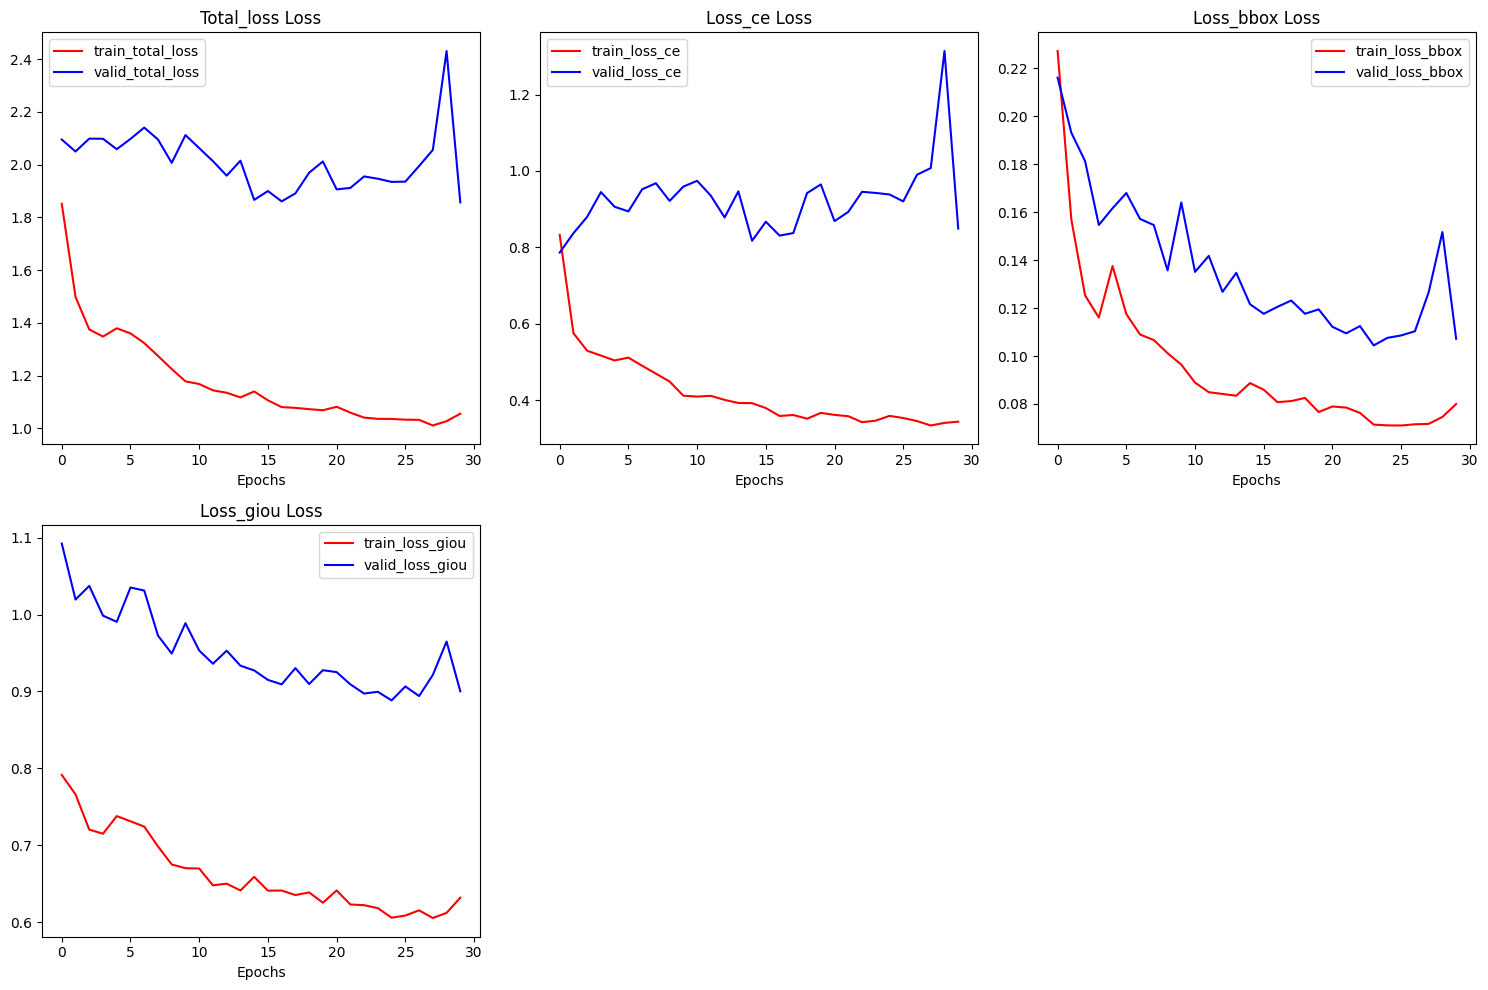

In [37]:
losses_plot = ['total_loss', 'loss_ce', 'loss_bbox', 'loss_giou']

plot_loss_values(total_results_train, total_results_valid, losses_plot)

In [38]:
torch.cuda.empty_cache()

In [39]:
device = torch.device('cuda')
LR_DETR_SEG = 1e-4
losses = ['labels', 'boxes', 'cardinality', 'masks']
weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1, 'loss_mask:': 1, 'loss_dice': 1}

criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)

# Set segmentation parameters to not require gradients
set_requires_grad(model.model.bbox_attention, False)
set_requires_grad(model.model.mask_head, False)
set_requires_grad(model.model.detr, False)
set_requires_grad(model.bbox_attention, True)
set_requires_grad(model.mask_head, True)


# Initialize the optimizer with only detection parameters
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_DETR_SEG)

# # Verify settings
# for name, param in model.named_parameters():
#     print(name, param.requires_grad)

EPOCHS_DETR_SEG = 50
best_loss = 10**5
total_results_train_seg = []
total_results_valid_seg = []

for epoch in range(EPOCHS_DETR_SEG):
    train_loss ,results_train= train_fn(dl_train, model,criterion, optimizer,device,scheduler=None,epoch=epoch,train_segmentation=True)
    total_results_train_seg.append(copy.deepcopy(results_train))
    valid_loss ,results_valid= eval_fn(dl_val, model,criterion, device)
    total_results_valid_seg.append(copy.deepcopy(results_valid))

    print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))

    if valid_loss.avg < best_loss:
        best_loss = valid_loss.avg
        print('Best model found for Fold {} in Epoch {}........Saving Model', epoch+1)
        torch.save(model.state_dict(), f'detr_best_{epoch}.pth')

100%|██████████| 303/303 [01:56<00:00,  2.59it/s, loss=0.758]


Loss value loss_dice with the final loss 0.7577949030072776


100%|██████████| 300/300 [00:44<00:00,  6.68it/s, loss=2.84]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.9785052293539047
|EPOCH 1| TRAIN_LOSS 0.7577949030072776| VALID_LOSS 2.835081861813863|
Best model found for Fold {} in Epoch {}........Saving Model 1


100%|██████████| 303/303 [01:54<00:00,  2.65it/s, loss=0.743]


Loss value loss_dice with the final loss 0.7434338727603258


100%|██████████| 300/300 [00:44<00:00,  6.69it/s, loss=2.83]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.9701029402017594
|EPOCH 2| TRAIN_LOSS 0.7434338727603258| VALID_LOSS 2.8266795726617175|
Best model found for Fold {} in Epoch {}........Saving Model 2


100%|██████████| 303/303 [01:56<00:00,  2.61it/s, loss=0.745]


Loss value loss_dice with the final loss 0.7445286439590328


100%|██████████| 300/300 [00:44<00:00,  6.69it/s, loss=2.82]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.9612393814325333
|EPOCH 3| TRAIN_LOSS 0.7445286439590328| VALID_LOSS 2.817816017071406|
Best model found for Fold {} in Epoch {}........Saving Model 3


100%|██████████| 303/303 [01:56<00:00,  2.61it/s, loss=0.734]


Loss value loss_dice with the final loss 0.7341718136182319


100%|██████████| 300/300 [00:44<00:00,  6.70it/s, loss=2.79]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.9377109382549922
|EPOCH 4| TRAIN_LOSS 0.7341718136182319| VALID_LOSS 2.7942875635623934|
Best model found for Fold {} in Epoch {}........Saving Model 4


100%|██████████| 303/303 [01:54<00:00,  2.66it/s, loss=0.697]


Loss value loss_dice with the final loss 0.6970670704696045


100%|██████████| 300/300 [00:44<00:00,  6.67it/s, loss=2.71]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.8542625403404236
|EPOCH 5| TRAIN_LOSS 0.6970670704696045| VALID_LOSS 2.710839172999064|
Best model found for Fold {} in Epoch {}........Saving Model 5


100%|██████████| 303/303 [01:53<00:00,  2.67it/s, loss=0.594]


Loss value loss_dice with the final loss 0.5941599940899576


100%|██████████| 300/300 [00:44<00:00,  6.67it/s, loss=2.61]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.7530114902059237
|EPOCH 6| TRAIN_LOSS 0.5941599940899576| VALID_LOSS 2.6095881259441374|
Best model found for Fold {} in Epoch {}........Saving Model 6


100%|██████████| 303/303 [01:55<00:00,  2.61it/s, loss=0.502]


Loss value loss_dice with the final loss 0.5016372840691714


100%|██████████| 300/300 [00:44<00:00,  6.69it/s, loss=2.56]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.7039848030606906
|EPOCH 7| TRAIN_LOSS 0.5016372840691714| VALID_LOSS 2.5605614276727042|
Best model found for Fold {} in Epoch {}........Saving Model 7


100%|██████████| 303/303 [01:53<00:00,  2.66it/s, loss=0.476]


Loss value loss_dice with the final loss 0.4756733596128206


100%|██████████| 300/300 [00:44<00:00,  6.69it/s, loss=2.53]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.676110971570015
|EPOCH 8| TRAIN_LOSS 0.4756733596128206| VALID_LOSS 2.5326876024405163|
Best model found for Fold {} in Epoch {}........Saving Model 8


100%|██████████| 303/303 [01:56<00:00,  2.60it/s, loss=0.466]


Loss value loss_dice with the final loss 0.4656077463044585


100%|██████████| 300/300 [00:44<00:00,  6.67it/s, loss=2.52]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6594935876131057
|EPOCH 9| TRAIN_LOSS 0.4656077463044585| VALID_LOSS 2.516070218880971|
Best model found for Fold {} in Epoch {}........Saving Model 9


100%|██████████| 303/303 [01:54<00:00,  2.65it/s, loss=0.45]


Loss value loss_dice with the final loss 0.4501565234987649


100%|██████████| 300/300 [00:44<00:00,  6.69it/s, loss=2.53]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6780319290359815
|EPOCH 10| TRAIN_LOSS 0.4501565234987649| VALID_LOSS 2.534608564376831|


100%|██████████| 303/303 [01:56<00:00,  2.60it/s, loss=0.459]


Loss value loss_dice with the final loss 0.4586992348381395


100%|██████████| 300/300 [00:44<00:00,  6.69it/s, loss=2.51]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6498208412528038
|EPOCH 11| TRAIN_LOSS 0.4586992348381395| VALID_LOSS 2.5063974674542746|
Best model found for Fold {} in Epoch {}........Saving Model 11


100%|██████████| 303/303 [01:55<00:00,  2.62it/s, loss=0.448]


Loss value loss_dice with the final loss 0.44803948769278257


100%|██████████| 300/300 [00:44<00:00,  6.71it/s, loss=2.5]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6448524312178294
|EPOCH 12| TRAIN_LOSS 0.44803948769278257| VALID_LOSS 2.5014290603001914|
Best model found for Fold {} in Epoch {}........Saving Model 12


100%|██████████| 303/303 [01:55<00:00,  2.63it/s, loss=0.444]


Loss value loss_dice with the final loss 0.4443671875956035


100%|██████████| 300/300 [00:45<00:00,  6.63it/s, loss=2.51]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.656410516500473
|EPOCH 13| TRAIN_LOSS 0.4443671875956035| VALID_LOSS 2.5129871491591134|


100%|██████████| 303/303 [01:54<00:00,  2.64it/s, loss=0.443]


Loss value loss_dice with the final loss 0.443370847369578


100%|██████████| 300/300 [00:45<00:00,  6.63it/s, loss=2.5]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6463660723964373
|EPOCH 14| TRAIN_LOSS 0.443370847369578| VALID_LOSS 2.5029427059491476|


100%|██████████| 303/303 [01:56<00:00,  2.61it/s, loss=0.438]


Loss value loss_dice with the final loss 0.4381547693175451


100%|██████████| 300/300 [00:45<00:00,  6.61it/s, loss=2.5]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6398354903856913
|EPOCH 15| TRAIN_LOSS 0.4381547693175451| VALID_LOSS 2.4964121162891386|
Best model found for Fold {} in Epoch {}........Saving Model 15


100%|██████████| 303/303 [01:55<00:00,  2.62it/s, loss=0.441]


Loss value loss_dice with the final loss 0.44092557488298256


100%|██████████| 300/300 [00:45<00:00,  6.61it/s, loss=2.51]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6535074438651403
|EPOCH 16| TRAIN_LOSS 0.44092557488298256| VALID_LOSS 2.510084079504013|


100%|██████████| 303/303 [01:53<00:00,  2.67it/s, loss=0.432]


Loss value loss_dice with the final loss 0.43213345597286035


100%|██████████| 300/300 [00:45<00:00,  6.61it/s, loss=2.5]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6393642582496007
|EPOCH 17| TRAIN_LOSS 0.43213345597286035| VALID_LOSS 2.49594088713328|
Best model found for Fold {} in Epoch {}........Saving Model 17


100%|██████████| 303/303 [01:55<00:00,  2.63it/s, loss=0.43]


Loss value loss_dice with the final loss 0.42977049892688346


100%|██████████| 300/300 [00:45<00:00,  6.63it/s, loss=2.49]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6331911544998486
|EPOCH 18| TRAIN_LOSS 0.42977049892688346| VALID_LOSS 2.489767781496048|
Best model found for Fold {} in Epoch {}........Saving Model 18


100%|██████████| 303/303 [01:56<00:00,  2.60it/s, loss=0.43]


Loss value loss_dice with the final loss 0.4297688480946097


100%|██████████| 300/300 [00:45<00:00,  6.64it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6283723710477352
|EPOCH 19| TRAIN_LOSS 0.4297688480946097| VALID_LOSS 2.4849489935239157|
Best model found for Fold {} in Epoch {}........Saving Model 19


100%|██████████| 303/303 [01:54<00:00,  2.64it/s, loss=0.425]


Loss value loss_dice with the final loss 0.4248947188897495


100%|██████████| 300/300 [00:45<00:00,  6.64it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6273883701364199
|EPOCH 20| TRAIN_LOSS 0.4248947188897495| VALID_LOSS 2.4839649931589762|
Best model found for Fold {} in Epoch {}........Saving Model 20


100%|██████████| 303/303 [01:56<00:00,  2.61it/s, loss=0.422]


Loss value loss_dice with the final loss 0.4216493643058015


100%|██████████| 300/300 [00:45<00:00,  6.62it/s, loss=2.5]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.639085984180371
|EPOCH 21| TRAIN_LOSS 0.4216493643058015| VALID_LOSS 2.4956626089413962|


100%|██████████| 303/303 [01:53<00:00,  2.66it/s, loss=0.423]


Loss value loss_dice with the final loss 0.4227925501149086


100%|██████████| 300/300 [00:45<00:00,  6.65it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6275735685726007
|EPOCH 22| TRAIN_LOSS 0.4227925501149086| VALID_LOSS 2.4841501998901365|


100%|██████████| 303/303 [01:55<00:00,  2.63it/s, loss=0.422]


Loss value loss_dice with the final loss 0.4222848799460792


100%|██████████| 300/300 [00:45<00:00,  6.62it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6254608004291853
|EPOCH 23| TRAIN_LOSS 0.4222848799460792| VALID_LOSS 2.4820374341805778|
Best model found for Fold {} in Epoch {}........Saving Model 23


100%|██████████| 303/303 [02:00<00:00,  2.52it/s, loss=0.431]


Loss value loss_dice with the final loss 0.4307976223454617


100%|██████████| 300/300 [00:45<00:00,  6.63it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6281542501350244
|EPOCH 24| TRAIN_LOSS 0.4307976223454617| VALID_LOSS 2.484730878273646|


100%|██████████| 303/303 [01:55<00:00,  2.63it/s, loss=0.426]


Loss value loss_dice with the final loss 0.4261645987974142


100%|██████████| 300/300 [00:45<00:00,  6.65it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6214404396216074
|EPOCH 25| TRAIN_LOSS 0.4261645987974142| VALID_LOSS 2.4780170774459838|
Best model found for Fold {} in Epoch {}........Saving Model 25


100%|██████████| 303/303 [01:56<00:00,  2.59it/s, loss=0.426]


Loss value loss_dice with the final loss 0.4261002697960378


100%|██████████| 300/300 [00:45<00:00,  6.64it/s, loss=2.49]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6353191562990348
|EPOCH 26| TRAIN_LOSS 0.4261002697960378| VALID_LOSS 2.4918957817554475|


100%|██████████| 303/303 [01:56<00:00,  2.60it/s, loss=0.422]


Loss value loss_dice with the final loss 0.422270804643631


100%|██████████| 300/300 [00:45<00:00,  6.65it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6209224678079287
|EPOCH 27| TRAIN_LOSS 0.422270804643631| VALID_LOSS 2.4774990944067636|
Best model found for Fold {} in Epoch {}........Saving Model 27


100%|██████████| 303/303 [01:56<00:00,  2.61it/s, loss=0.418]


Loss value loss_dice with the final loss 0.41814339485498936


100%|██████████| 300/300 [00:45<00:00,  6.64it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6236142355203629
|EPOCH 28| TRAIN_LOSS 0.41814339485498936| VALID_LOSS 2.4801908620198567|


100%|██████████| 303/303 [02:01<00:00,  2.50it/s, loss=0.425]


Loss value loss_dice with the final loss 0.4245672322834286


100%|██████████| 300/300 [00:45<00:00,  6.61it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.624833417882522
|EPOCH 29| TRAIN_LOSS 0.4245672322834286| VALID_LOSS 2.481410046418508|


100%|██████████| 303/303 [02:00<00:00,  2.51it/s, loss=0.42]


Loss value loss_dice with the final loss 0.4200917585651473


100%|██████████| 300/300 [00:45<00:00,  6.62it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6230936132371425
|EPOCH 30| TRAIN_LOSS 0.4200917585651473| VALID_LOSS 2.479670247634252|


100%|██████████| 303/303 [01:57<00:00,  2.58it/s, loss=0.419]


Loss value loss_dice with the final loss 0.4187019714231145


100%|██████████| 300/300 [00:45<00:00,  6.60it/s, loss=2.47]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6173706983526548
|EPOCH 31| TRAIN_LOSS 0.4187019714231145| VALID_LOSS 2.473947333097458|
Best model found for Fold {} in Epoch {}........Saving Model 31


100%|██████████| 303/303 [01:55<00:00,  2.63it/s, loss=0.424]


Loss value loss_dice with the final loss 0.4242296106252733


100%|██████████| 300/300 [00:44<00:00,  6.70it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6253489452600479
|EPOCH 32| TRAIN_LOSS 0.4242296106252733| VALID_LOSS 2.4819255721569062|


100%|██████████| 303/303 [01:54<00:00,  2.64it/s, loss=0.416]


Loss value loss_dice with the final loss 0.41627337156545996


100%|██████████| 300/300 [00:44<00:00,  6.71it/s, loss=2.47]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6167198550204436
|EPOCH 33| TRAIN_LOSS 0.41627337156545996| VALID_LOSS 2.4732964857419333|
Best model found for Fold {} in Epoch {}........Saving Model 33


100%|██████████| 303/303 [01:55<00:00,  2.63it/s, loss=0.416]


Loss value loss_dice with the final loss 0.4162163183634037


100%|██████████| 300/300 [00:44<00:00,  6.69it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6258631259202957
|EPOCH 34| TRAIN_LOSS 0.4162163183634037| VALID_LOSS 2.4824397587776184|


100%|██████████| 303/303 [01:51<00:00,  2.71it/s, loss=0.413]


Loss value loss_dice with the final loss 0.4130128850244453


100%|██████████| 300/300 [00:45<00:00,  6.66it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6232946718235811
|EPOCH 35| TRAIN_LOSS 0.4130128850244453| VALID_LOSS 2.4798712972799937|


100%|██████████| 303/303 [01:54<00:00,  2.65it/s, loss=0.42]


Loss value loss_dice with the final loss 0.41981330794273036


100%|██████████| 300/300 [00:44<00:00,  6.69it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6207868245244026
|EPOCH 36| TRAIN_LOSS 0.41981330794273036| VALID_LOSS 2.477363462050756|


100%|██████████| 303/303 [01:55<00:00,  2.63it/s, loss=0.413]


Loss value loss_dice with the final loss 0.41284788648287457


100%|██████████| 300/300 [00:44<00:00,  6.70it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6188451415300369
|EPOCH 37| TRAIN_LOSS 0.41284788648287457| VALID_LOSS 2.4754217763741813|


100%|██████████| 303/303 [01:56<00:00,  2.60it/s, loss=0.41]


Loss value loss_dice with the final loss 0.4100758784970041


100%|██████████| 300/300 [00:44<00:00,  6.68it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6202542431155841
|EPOCH 38| TRAIN_LOSS 0.4100758784970041| VALID_LOSS 2.476830869515737|


100%|██████████| 303/303 [01:54<00:00,  2.64it/s, loss=0.418]


Loss value loss_dice with the final loss 0.4181116694959477


100%|██████████| 300/300 [00:44<00:00,  6.68it/s, loss=2.49]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6293129940827688
|EPOCH 39| TRAIN_LOSS 0.4181116694959477| VALID_LOSS 2.485889629125595|


100%|██████████| 303/303 [01:55<00:00,  2.63it/s, loss=0.41]


Loss value loss_dice with the final loss 0.4104591128062887


100%|██████████| 300/300 [00:44<00:00,  6.68it/s, loss=2.47]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6164657226204873
|EPOCH 40| TRAIN_LOSS 0.4104591128062887| VALID_LOSS 2.4730423577626546|
Best model found for Fold {} in Epoch {}........Saving Model 40


100%|██████████| 303/303 [01:54<00:00,  2.65it/s, loss=0.412]


Loss value loss_dice with the final loss 0.4122942916729269


100%|██████████| 300/300 [00:44<00:00,  6.68it/s, loss=2.47]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6119800959527493
|EPOCH 41| TRAIN_LOSS 0.4122942916729269| VALID_LOSS 2.468556723197301|
Best model found for Fold {} in Epoch {}........Saving Model 41


100%|██████████| 303/303 [01:51<00:00,  2.71it/s, loss=0.42]


Loss value loss_dice with the final loss 0.4204078012272076


100%|██████████| 300/300 [00:44<00:00,  6.70it/s, loss=2.47]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6141475529472034
|EPOCH 42| TRAIN_LOSS 0.4204078012272076| VALID_LOSS 2.4707241841157277|


100%|██████████| 303/303 [01:57<00:00,  2.57it/s, loss=0.41]


Loss value loss_dice with the final loss 0.4097022286342709


100%|██████████| 300/300 [00:44<00:00,  6.69it/s, loss=2.47]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.616717072079579
|EPOCH 43| TRAIN_LOSS 0.4097022286342709| VALID_LOSS 2.4732937026023865|


100%|██████████| 303/303 [02:00<00:00,  2.52it/s, loss=0.41]


Loss value loss_dice with the final loss 0.40966258313592907


100%|██████████| 300/300 [00:44<00:00,  6.68it/s, loss=2.47]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6169572148223718
|EPOCH 44| TRAIN_LOSS 0.40966258313592907| VALID_LOSS 2.473533847729365|


100%|██████████| 303/303 [01:54<00:00,  2.64it/s, loss=0.41]


Loss value loss_dice with the final loss 0.4099698306703725


100%|██████████| 300/300 [00:44<00:00,  6.68it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6200217279791832
|EPOCH 45| TRAIN_LOSS 0.4099698306703725| VALID_LOSS 2.47659836769104|


100%|██████████| 303/303 [01:51<00:00,  2.73it/s, loss=0.409]


Loss value loss_dice with the final loss 0.4090615907813063


100%|██████████| 300/300 [00:44<00:00,  6.69it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6263598677019279
|EPOCH 46| TRAIN_LOSS 0.4090615907813063| VALID_LOSS 2.482936495145162|


100%|██████████| 303/303 [01:55<00:00,  2.62it/s, loss=0.411]


Loss value loss_dice with the final loss 0.4112830562855151


100%|██████████| 300/300 [00:44<00:00,  6.71it/s, loss=2.48]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.624323072185119
|EPOCH 47| TRAIN_LOSS 0.4112830562855151| VALID_LOSS 2.4808997027079265|


100%|██████████| 303/303 [01:56<00:00,  2.60it/s, loss=0.41]


Loss value loss_dice with the final loss 0.4095841472101684


100%|██████████| 300/300 [00:45<00:00,  6.66it/s, loss=2.47]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6140819668769837
|EPOCH 48| TRAIN_LOSS 0.4095841472101684| VALID_LOSS 2.4706585919857025|


100%|██████████| 303/303 [01:52<00:00,  2.70it/s, loss=0.41]


Loss value loss_dice with the final loss 0.41011377578914754


100%|██████████| 300/300 [00:44<00:00,  6.68it/s, loss=2.47]


Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6146411976218223
|EPOCH 49| TRAIN_LOSS 0.41011377578914754| VALID_LOSS 2.4712178258101147|


100%|██████████| 303/303 [01:52<00:00,  2.70it/s, loss=0.409]


Loss value loss_dice with the final loss 0.40871341024885083


100%|██████████| 300/300 [00:44<00:00,  6.69it/s, loss=2.47]

Loss value loss_ce with the final loss 0.8491960910707712
Loss value loss_bbox with the final loss 0.10720751602202654
Loss value loss_giou with the final loss 0.9001730248332024
Loss value loss_dice with the final loss 0.6139571126798788
|EPOCH 50| TRAIN_LOSS 0.40871341024885083| VALID_LOSS 2.470533745288849|


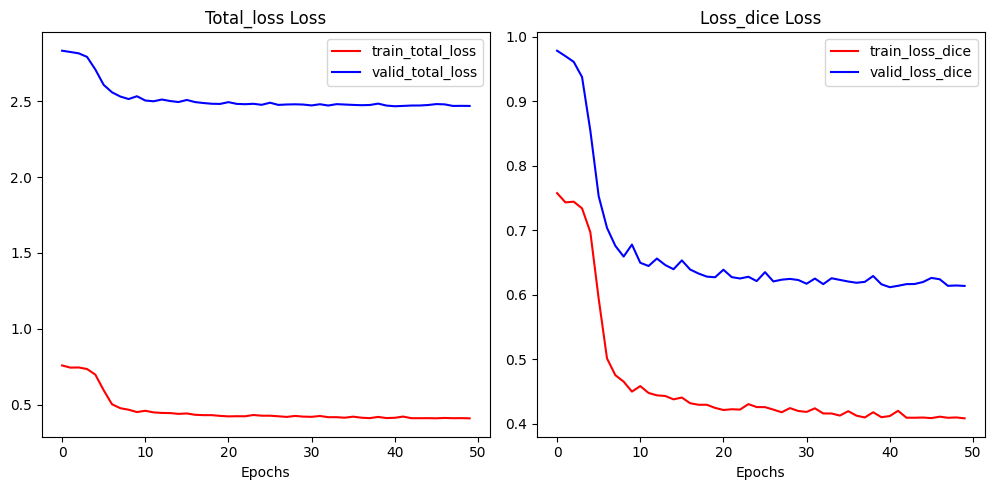

In [40]:
losses_plot = ['total_loss',  'loss_dice']

plot_loss_values(total_results_train_seg, total_results_valid_seg, losses_plot)

## 4.2 Engine Coco Eval

in this chapter we finally evaluate the model by predictiong from the valid dataset the predictions und feed the COCO API accordingly.

In [41]:

device = torch.device('cuda')
losses = ['labels', 'boxes', 'cardinality', 'masks']
weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1, 'loss_mask:':1, 'loss_dice': 1}

criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)

valid_loss, results_valid = eval_fn_coco(dl_val, model,criterion, device, train_segmentation=True)
#print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))


  1%|          | 3/300 [00:01<02:35,  1.91it/s, loss=2.21]<ipython-input-26-30c891e4f40a>:20: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 300/300 [00:27<00:00, 10.97it/s, loss=2.57]


Loss value loss_ce with the final loss 0.9068220019340515
Loss value loss_bbox with the final loss 0.10458691827952862
Loss value loss_giou with the final loss 0.9384536027908326
Loss value loss_dice with the final loss 0.6197958797216415
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.30s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets

# 5.Sample

this section make some random predictions from the model and display them against the ground Truth data to give an overview how good the model really predicts and where the weaknesses are.

We are using here several methods for providing us transformation from predictions to the final plot:

* `filter_boxes`: filters some boxes which have a probability > 0.5 and where the model predicts really a object and not class 4: No_object
* `filter_masks`: filters some masks which have a probability > 0.5 and where the model predicts really a object and not class 4: No_object
* `denormalize_and_convert_bbox` transformation needed from the output by denormalization and finally convert it to a bounding box
* `denormalize_and_convert_bbox_xyxy` transformation needed from the output by denormalization and finally convert it to a bounding box. Change it to the xyxy format for displaying


In [ ]:
def filter_boxes(predictions):
    filtered_masks = []
    boxes = predictions["pred_boxes"].squeeze()
    logits = predictions["pred_logits"].squeeze()
    #print("box shape is ", boxes.shape)
    # Compute probabilities using softmax on logits for each class (excluding the no-element class if it's the last one)
    probabilities = torch.softmax(logits, dim=-1)

    for index, (box, prob) in enumerate(zip(boxes, probabilities)):
        max_prob, max_index = torch.max(prob, dim=0)  # Get the max probability and the corresponding class index
        if max_index != 3:  # Assuming class index 3 is 'no-label found'
            if max_prob > 0.5:  # Replace 0.5 with the minimum score threshold for this class if you have a dict
                box_array = box.cpu().numpy().squeeze()  # Convert the box to a numpy array and remove extra dimensions
                #print("box array shape is : ", box_array.shape)
                #print("box array is : ", box_array)
                #high_confidence_mask = box_array > MASK_THRESHOLD_DICT[max_index.item()]  # Threshold for this class
                #high_confidence_mask = eliminate_overlaps(box_array, filtered_masks)
                #print("high_confidence_mask shape is : ", box_array.shape)
                #print("high_confidence_mask is : ", box_array)
                filtered_masks.append(box_array)

    print(len(filtered_masks))
    return filtered_masks

In [ ]:
def filter_masks(predictions_logits, prediction_maks):
    filtered_masks = []
    masks = prediction_maks.squeeze()
    logits = predictions_logits.squeeze()
    #print("box shape is ", boxes.shape)
    # Compute probabilities using softmax on logits for each class (excluding the no-element class if it's the last one)
    probabilities = torch.softmax(logits, dim=-1)

    for index, (mask, prob) in enumerate(zip(masks, probabilities)):
        max_prob, max_index = torch.max(prob, dim=0)  # Get the max probability and the corresponding class index
        if max_index != 3:  # Assuming class index 3 is 'no-label found'
            if max_prob > 0.5:  # Replace 0.5 with the minimum score threshold for this class if you have a dict
                box_array = mask.cpu().numpy().squeeze()  # Convert the box to a numpy array and remove extra dimensions
                #print("box array shape is : ", box_array.shape)
                #print("box array is : ", box_array)
                #high_confidence_mask = box_array > MASK_THRESHOLD_DICT[max_index.item()]  # Threshold for this class
                #high_confidence_mask = eliminate_overlaps(box_array, filtered_masks)
                #print("high_confidence_mask shape is : ", box_array.shape)
                #print("high_confidence_mask is : ", box_array)
                filtered_masks.append(box_array)

    print(len(filtered_masks))
    return filtered_masks

In [44]:
def denormalize_and_convert_bbox(bboxes, image_height, image_width):
    """
    Denormalize bounding boxes from normalized cxcywh to COCO format (xywh) in pixel dimensions.
    """
    denormalized_converted_bboxes = []
    for bbox in bboxes:
        # Denormalize
        cx, cy, w, h = bbox
        cx_denorm = cx * image_width
        cy_denorm = cy * image_height
        w_denorm = w * image_width
        h_denorm = h * image_height

        # Convert cxcywh to xywh for COCO
        x_min = cx_denorm - (w_denorm / 2)
        y_min = cy_denorm - (h_denorm / 2)
        xywh_bbox = [x_min, y_min, w_denorm, h_denorm]

        denormalized_converted_bboxes.append(xywh_bbox)
    return denormalized_converted_bboxes


def denormalize_and_convert_bbox_xyxy(bboxes, image_height, image_width):
    """
    Denormalize bounding boxes from normalized cxcywh to COCO format (xywh) in pixel dimensions.
    """
    denormalized_converted_bboxes = []
    for bbox in bboxes:
        # Denormalize
        cx, cy, w, h = bbox
        cx_denorm = cx * image_width
        cy_denorm = cy * image_height
        w_denorm = w * image_width
        h_denorm = h * image_height

        # Convert cxcywh to xyxy
        x_min = cx_denorm - (w_denorm / 2)
        y_min = cy_denorm - (h_denorm / 2)
        x_max = cx_denorm + (w_denorm / 2)
        y_max = cy_denorm + (h_denorm / 2)
        xyxy_bbox = [x_min, y_min, x_max, y_max]

        denormalized_converted_bboxes.append(xyxy_bbox)


    return denormalized_converted_bboxes

42
42


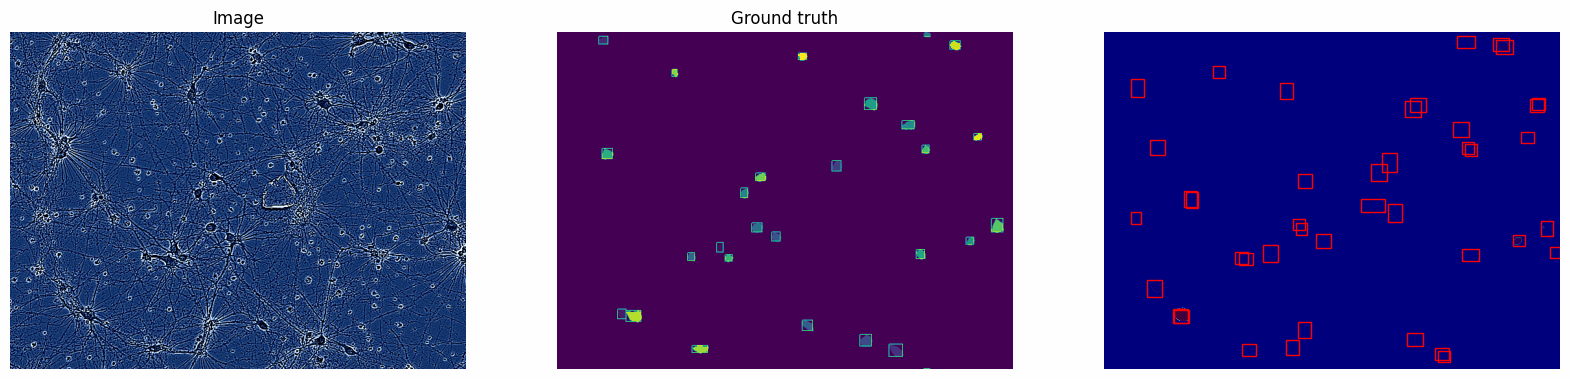

In [45]:
 #Plots: the image, The image + the ground truth mask + detection boxes, The image + the predicted mask + predicted boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import random



def add_boxes(ax, boxes, color='red'):
    """Add bounding boxes to the plot."""
    for box in boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                 linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

def plot_image_boxes_and_masks(image, boxes, masks, ax=None, mask_alpha=0.5, box_color='red'):
    """
    Plot an image with overlaid masks and bounding boxes.

    Args:
    - image: The image as a NumPy array.
    - boxes: A list of [xmin, ymin, xmax, ymax] boxes.
    - masks: A binary mask array of shape [num_masks, height, width].
    - ax: Matplotlib axis object to plot on.
    - mask_alpha: Transparency level of the masks.
    - box_color: Color for the bounding boxes.
    """
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(12, 8))

    # Show the image
    ax.imshow(image)

    # Overlay masks
    for mask in masks:
        ax.imshow(mask, cmap='jet', alpha=mask_alpha)  # 'jet' gives a distinctive color to the mask

    # Add boxes
    add_boxes(ax, boxes, color=box_color)

    ax.axis('off')  # Hide the axes ticks
    plt.show()


def apply_sigmoid_and_threshold(masks, threshold=0.5):
    # Convert logits to probabilities
    probabilities = torch.sigmoid(masks)
    # Apply threshold
    binary_masks = (probabilities > threshold).float()
    return binary_masks


def analyze_sample(model, ds_train, sample_index):
    '''
    model : model used to create the masks/boxes of the object detection
    ds_train : data set to take samples from
    sample_index: index of the image that will be used
    Returns grid 1x3 with : the image | the image + the ground truth mask + detection boxes | the image + the predicted mask + predicted boxes
    '''

    for i, batch in enumerate(dl_train, start=1):
      if i < 200:
        images, targets = batch


        #print(f"Training Image {targets['file_path'][0]}")

        # img, targets = ds_train[sample_index]
        # img_input = img.unsqueeze(0)
        img = images[0]
        img_1 = img.unsqueeze(dim=0)
        img_input = img_1.to(device)
        with torch.no_grad():
          #print(img_input.shape)

          preds = model(img_input)
          #print("Boxes are: ", preds['pred_boxes'])
          #print("Maks  are: ", preds['pred_masks'])

          probabilities = torch.sigmoid(preds['pred_logits'])
          # Find the indices of the max probabilities
          max_indices = torch.argmax(probabilities, dim=-1)
          #print(max_indices)
          not_last_index_count = torch.sum(max_indices != (4 - 1))
          #print("targets type ", type(targets['labels']) )
          #print("targets len ", len(targets['labels']) )
          num_objects_gt = targets['labels'][0].shape[0]
          #num_objects_gt = targets['labels'].shape[0]
          missing_objects = num_objects_gt-not_last_index_count
          #print(f"Objects found: {not_last_index_count.item()} objects loss: {missing_objects}", )
          binary_masks = apply_sigmoid_and_threshold(preds['pred_masks'])
          #print(preds['pred_logits'])
          filtered_preds = filter_boxes(preds)  # This should filter based on scores or other criteria
          filtered_masks = filter_masks(preds['pred_logits'], binary_masks)
          #print("Filtered Boxes are: ", filtered_preds)
          #print("Filtered Maks are: ", filtered_masks)
          # Convert boxes from normalized to pixel scale
          pred_boxes_original = denormalize_and_convert_bbox_xyxy(filtered_preds, img.shape[1], img.shape[2])
          seg_masks = filtered_masks  # Assuming this contains raw logits from the mask head
          #print("Segmasks are: " ,seg_masks)

          if not_last_index_count.item() > 5 and not_last_index_count.item() < 800 :
            break

    #print(pred_boxes_original)
    fig, axs = plt.subplots(1, 3, figsize=(20, 40), facecolor="#fefefe")

    masks = np.zeros((IMG_HEIGHT, IMG_WIDTH))
    boxes = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    axs[0].imshow(img.numpy().transpose((1,2,0)))
    axs[0].set_title("Image")
    axs[0].axis("off")


    for mask in targets['masks'][0]:
        box = find_bounding_box(mask)
        boxes = np.logical_or(boxes, create_boxed_image(box))

    masks = merge_masks(targets['masks'][0], 0.5)
    #masks = merge_masks(targets['masks'], 0.5)
    detections = merge_masks_and_boxes(masks, boxes)
    axs[1].imshow(detections)
    axs[1].set_title("Ground truth")
    axs[1].axis("off")
    #print("masks have shape",targets['masks'][0].shape)
    #print("masks have shape",targets['masks'][0][0])


    plot_image_boxes_and_masks(img.cpu().numpy().transpose((1,2,0)), pred_boxes_original, filtered_masks, ax=axs[2])
    # axs[2].imshow(img.cpu().numpy().transpose((1,2,0)))
    # axs[2].imshow(img.numpy().transpose(1, 2, 0))
    # add_boxes(axs[2], pred_boxes_original, color='red')



    axs[2].set_title("Image with Predicted Boxes")
    axs[2].axis("off")
    plt.show()
analyze_sample(model, train_dataset, 404)

#6.Conclusion and Summary

This code and project was very insigthful to bettter understand the detr model and how it works.

The following lessons learned I could notice:
* Transformers need rather more data to train,
* The detr was pretrained on the coco set but just with a specific configuration, therefore the model could be just used for this configuration, otherwhise learning from scratch is needed
* instance segmentation is much harder than semantic segmentation
* GPU computation rahter high in such a model configuration. especially with different heads (classification, bounding box, segmentation)

Becuase of limited time, the following improvements could still be made:
* advanced augmentation before training like try to generate a synthesised image to get for samples
* longer training, higher batchsize with better computation ressources.
* Adapt num_queries to detect more objects but then train from scratch without pretrained weigths
